In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
# from custom_classes_defs.unet0 import * 
# from custom_classes_defs.Unet_like import *  
# from custom_classes_defs.unet import *  
from custom_classes_defs.fnet0 import *
# from custom_classes_defs.fnet_like import *
# from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 512
EPOCHS = 200
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-06-01 20:30:39.292303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 20:30:39.292971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 20:30:39.407157: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-01 20:30:39.615120: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi
    
if NUM_GPU>1:
    strategy = tf.distribute.MirroredStrategy()
    # strategy = tf.distribute.MultiWorkerMirroredStrategy()
    BATCH_SIZE = strategy.num_replicas_in_sync * BATCH_SIZE

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1
/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Sat Jun  1 20:31:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:01:00.0 Off |                    0 |
| N/A   27C    P0              58W / 400W |    698MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

|   2  NVIDIA A100-SXM4-40GB          Off | 00000000:81:00.0 Off |                    0 |
| N/A   42C    P0             243W / 400W |  38244MiB / 40960MiB |     98%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   3  NVIDIA A100-SXM4-40GB          Off | 00000000:C1:00.0 Off |                    0 |
| N/A   26C    P0              56W / 400W |      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   G

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Images and annations for Thebe seismic data
start = time.time()
img_url = '../thebe_new/seismic'
target_url = '../thebe_new/fault'
seis = Thebe(img_url, target_url)
    
# Create datasets for respective data samples and labels
x_test, y_test = seis.data_generator('test', as_numpy=True)
        
print("Size of test data: {}".format(seis.test_size)) 

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


Size of test data: 224122
...elapsed time: ___ 0.40 minutes___


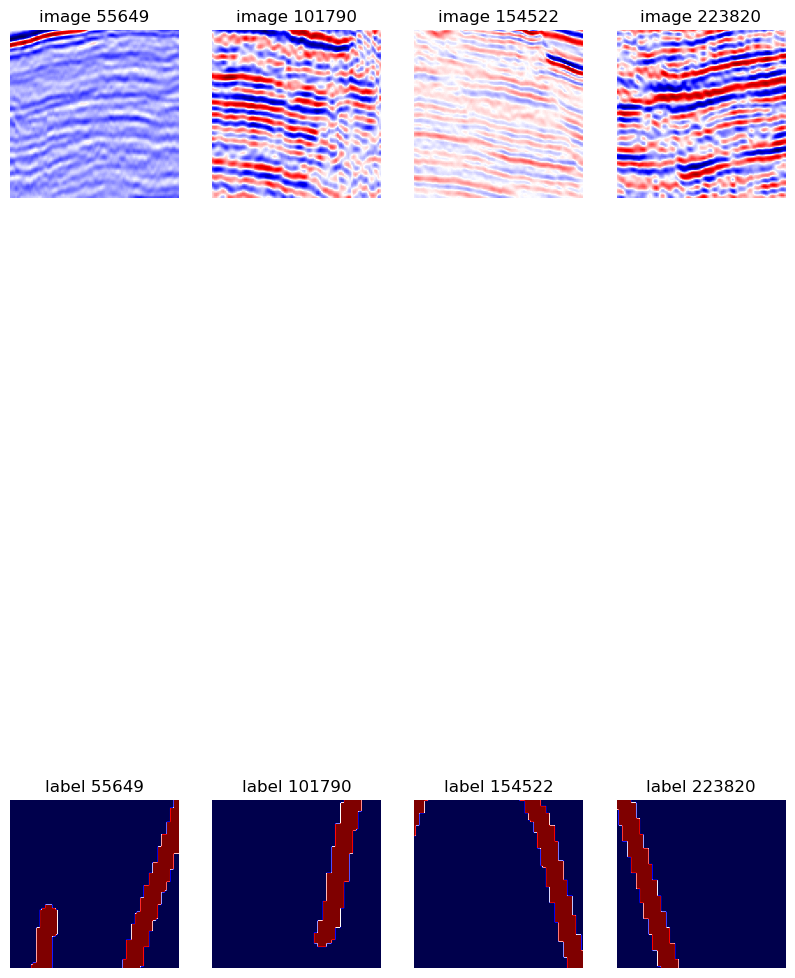

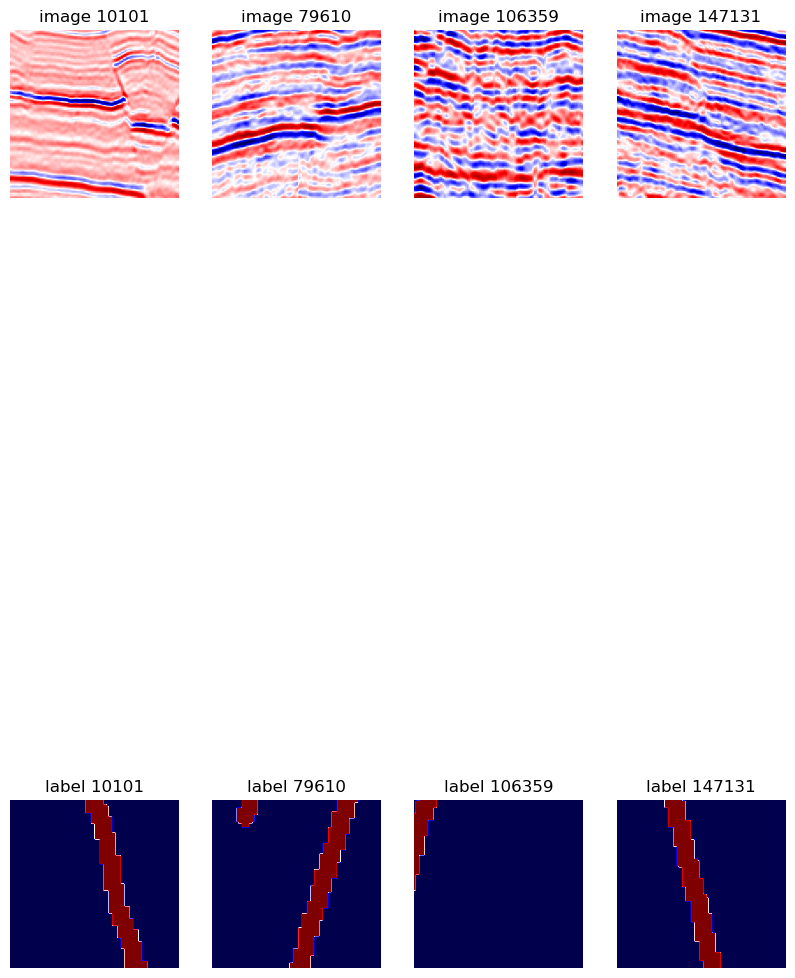

In [7]:
if INTERACTIVE_SESSION:
    seis.display_sample_images(x_test, y_test, num_images=4)
    seis.display_sample_images(x_test, y_test, num_images=4)


In [8]:
# Model configurations
conf = model_config(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./Thebe/fnet0',
    img_shape=seis.img_size,
    target_size=seis.img_size,
    threshold=seis.threshold,
    pos_label=seis.pos_label,
    train_size=seis.train_size,
    test_size=seis.test_size,
    multiple_gpu_device=(NUM_GPU>1),
    validation_size=seis.validation_size
)

assert not(conf.new_training_session)

conf.info()

2024-06-01 20:31:50.819532: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38379 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


             NUM_GPU: 1
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: False
           pos_label: 1
resume_training_session: 0
           save_path: ./Thebe/fnet0
           test_size: 224122
           threshold: 0.5
          train_size: None
       training_args:
                        epochs: 200
                    batch_size: 512
                       shuffle: True
                       verbose: 0
   training_duration: None
     validation_size: None


### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    print(f"Number of devices: {strategy.num_replicas_in_sync}")

# m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
model = m_obj.build_model()
# model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 7,339,681
Total trainable wieghts: 7,330,337
Total non-trainable wieghts: 9,344


### Train  model



	Train fnet model
-------------------------------------------------------


model train history 'model+_history.pickle'loaded!
             NUM_GPU: 1
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./Thebe/fnet0
           test_size: 66077
           threshold: 0.5
          train_size: 181029
       training_args:
                        epochs: 100
                    batch_size: 512
                       shuffle: True
                       verbose: 0
               validation_data: <class 'tensorflow.pytho

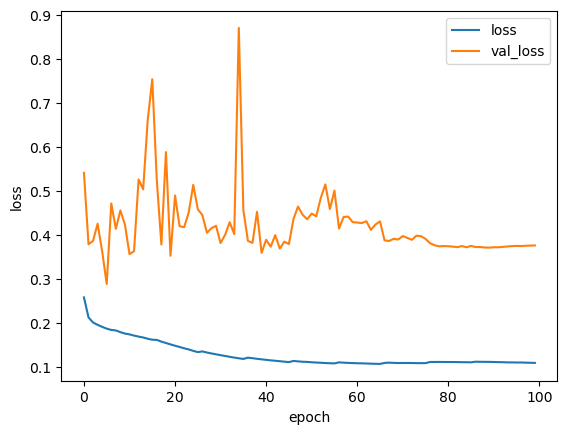

In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=None, 
        plot_history=INTERACTIVE_SESSION
)


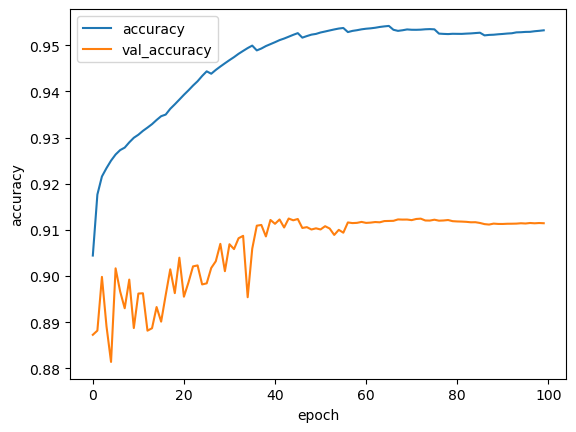

In [11]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['accuracy','val_accuracy'])

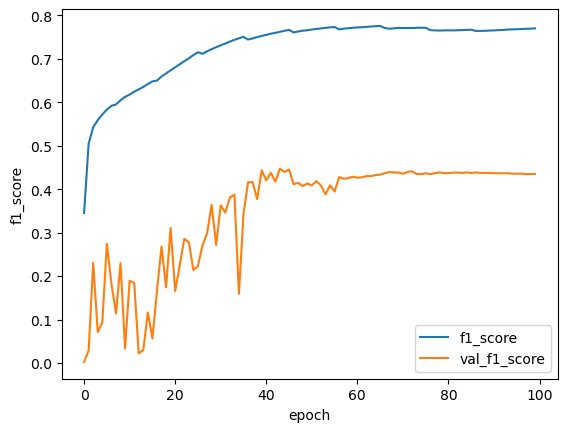

In [12]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['f1_score','val_f1_score'])

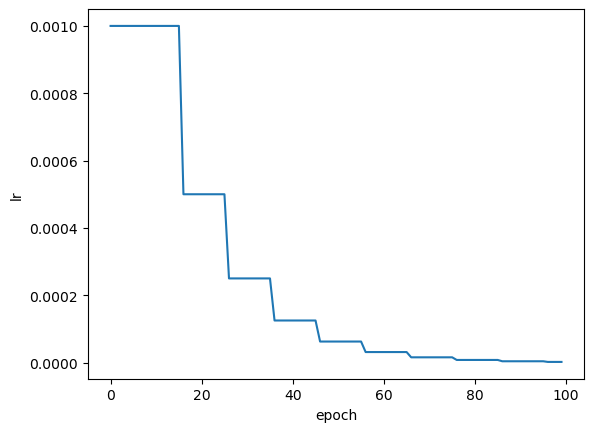

In [13]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, 'lr')

### Evaluate and Vizualize

In [14]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
start = time.time()
y_pred = model.predict(x_test)

start = time.time() - start
print("evaluation elapsed time:___{:5.2f}___minutes" \
                .format(start/60))




	Evaluate fnet model
-------------------------------------------------------


2024-06-01 20:33:10.046550: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


   1/7004 [..............................] - ETA: 17:51:25

   5/7004 [..............................] - ETA: 1:44    

   9/7004 [..............................] - ETA: 1:47

  13/7004 [..............................] - ETA: 1:45

  17/7004 [..............................] - ETA: 1:42

  21/7004 [..............................] - ETA: 1:40

  25/7004 [..............................] - ETA: 1:39

  29/7004 [..............................] - ETA: 1:38

  33/7004 [..............................] - ETA: 1:37

  37/7004 [..............................] - ETA: 1:37

  41/7004 [..............................] - ETA: 1:36

  45/7004 [..............................] - ETA: 1:36

  49/7004 [..............................] - ETA: 1:36

  53/7004 [..............................] - ETA: 1:35

  57/7004 [..............................] - ETA: 1:35

  61/7004 [..............................] - ETA: 1:35

  65/7004 [..............................] - ETA: 1:35

  69/7004 [..............................] - ETA: 1:35

  73/7004 [..............................] - ETA: 1:35

  77/7004 [..............................] - ETA: 1:34

  81/7004 [..............................] - ETA: 1:34

  85/7004 [..............................] - ETA: 1:34

  89/7004 [..............................] - ETA: 1:34

  93/7004 [..............................] - ETA: 1:34

  97/7004 [..............................] - ETA: 1:34

 101/7004 [..............................] - ETA: 1:34

 105/7004 [..............................] - ETA: 1:34

 109/7004 [..............................] - ETA: 1:34

 113/7004 [..............................] - ETA: 1:33

 117/7004 [..............................] - ETA: 1:33

 121/7004 [..............................] - ETA: 1:33

 125/7004 [..............................] - ETA: 1:33

 129/7004 [..............................] - ETA: 1:33

 133/7004 [..............................] - ETA: 1:33

 137/7004 [..............................] - ETA: 1:33

 141/7004 [..............................] - ETA: 1:33

 145/7004 [..............................] - ETA: 1:33

 149/7004 [..............................] - ETA: 1:33

 153/7004 [..............................] - ETA: 1:33

 157/7004 [..............................] - ETA: 1:32

 161/7004 [..............................] - ETA: 1:32

 165/7004 [..............................] - ETA: 1:32

 169/7004 [..............................] - ETA: 1:32

 173/7004 [..............................] - ETA: 1:32

 177/7004 [..............................] - ETA: 1:32

 181/7004 [..............................] - ETA: 1:32

 185/7004 [..............................] - ETA: 1:32

 189/7004 [..............................] - ETA: 1:32

 193/7004 [..............................] - ETA: 1:32

 197/7004 [..............................] - ETA: 1:32

 201/7004 [..............................] - ETA: 1:32

 205/7004 [..............................] - ETA: 1:32

 209/7004 [..............................] - ETA: 1:32

 213/7004 [..............................] - ETA: 1:32

 217/7004 [..............................] - ETA: 1:31

 221/7004 [..............................] - ETA: 1:31

 225/7004 [..............................] - ETA: 1:31

 229/7004 [..............................] - ETA: 1:31

 233/7004 [..............................] - ETA: 1:31

 237/7004 [>.............................] - ETA: 1:31

 241/7004 [>.............................] - ETA: 1:31

 245/7004 [>.............................] - ETA: 1:31

 249/7004 [>.............................] - ETA: 1:31

 253/7004 [>.............................] - ETA: 1:31

 257/7004 [>.............................] - ETA: 1:31

 261/7004 [>.............................] - ETA: 1:31

 265/7004 [>.............................] - ETA: 1:31

 269/7004 [>.............................] - ETA: 1:31

 273/7004 [>.............................] - ETA: 1:31

 277/7004 [>.............................] - ETA: 1:31

 281/7004 [>.............................] - ETA: 1:31

 285/7004 [>.............................] - ETA: 1:30

 289/7004 [>.............................] - ETA: 1:30

 293/7004 [>.............................] - ETA: 1:30

 297/7004 [>.............................] - ETA: 1:30

 301/7004 [>.............................] - ETA: 1:30

 305/7004 [>.............................] - ETA: 1:30

 309/7004 [>.............................] - ETA: 1:30

 313/7004 [>.............................] - ETA: 1:30

 317/7004 [>.............................] - ETA: 1:30

 321/7004 [>.............................] - ETA: 1:30

 325/7004 [>.............................] - ETA: 1:30

 329/7004 [>.............................] - ETA: 1:30

 333/7004 [>.............................] - ETA: 1:30

 337/7004 [>.............................] - ETA: 1:30

 341/7004 [>.............................] - ETA: 1:30

 345/7004 [>.............................] - ETA: 1:30

 349/7004 [>.............................] - ETA: 1:30

 353/7004 [>.............................] - ETA: 1:29

 357/7004 [>.............................] - ETA: 1:29

 361/7004 [>.............................] - ETA: 1:29

 365/7004 [>.............................] - ETA: 1:29

 369/7004 [>.............................] - ETA: 1:29

 373/7004 [>.............................] - ETA: 1:29

 377/7004 [>.............................] - ETA: 1:29

 381/7004 [>.............................] - ETA: 1:29

 385/7004 [>.............................] - ETA: 1:29

 389/7004 [>.............................] - ETA: 1:29

 393/7004 [>.............................] - ETA: 1:29

 397/7004 [>.............................] - ETA: 1:29

 401/7004 [>.............................] - ETA: 1:29

 405/7004 [>.............................] - ETA: 1:29

 409/7004 [>.............................] - ETA: 1:29

 413/7004 [>.............................] - ETA: 1:29

 417/7004 [>.............................] - ETA: 1:29

 421/7004 [>.............................] - ETA: 1:28

 425/7004 [>.............................] - ETA: 1:28

 429/7004 [>.............................] - ETA: 1:28

 433/7004 [>.............................] - ETA: 1:28

 437/7004 [>.............................] - ETA: 1:28

 441/7004 [>.............................] - ETA: 1:28

 445/7004 [>.............................] - ETA: 1:28

 449/7004 [>.............................] - ETA: 1:28

 453/7004 [>.............................] - ETA: 1:28

 457/7004 [>.............................] - ETA: 1:28

 461/7004 [>.............................] - ETA: 1:28

 465/7004 [>.............................] - ETA: 1:28

 469/7004 [=>............................] - ETA: 1:28

 473/7004 [=>............................] - ETA: 1:28

 477/7004 [=>............................] - ETA: 1:28

 481/7004 [=>............................] - ETA: 1:28

 485/7004 [=>............................] - ETA: 1:28

 489/7004 [=>............................] - ETA: 1:28

 493/7004 [=>............................] - ETA: 1:27

 497/7004 [=>............................] - ETA: 1:27

 501/7004 [=>............................] - ETA: 1:27

 505/7004 [=>............................] - ETA: 1:27

 509/7004 [=>............................] - ETA: 1:27

 513/7004 [=>............................] - ETA: 1:27

 517/7004 [=>............................] - ETA: 1:27

 521/7004 [=>............................] - ETA: 1:27

 525/7004 [=>............................] - ETA: 1:27

 529/7004 [=>............................] - ETA: 1:27

 533/7004 [=>............................] - ETA: 1:27

 537/7004 [=>............................] - ETA: 1:27

 541/7004 [=>............................] - ETA: 1:27

 545/7004 [=>............................] - ETA: 1:27

 549/7004 [=>............................] - ETA: 1:27

 553/7004 [=>............................] - ETA: 1:27

 557/7004 [=>............................] - ETA: 1:27

 561/7004 [=>............................] - ETA: 1:27

 565/7004 [=>............................] - ETA: 1:26

 569/7004 [=>............................] - ETA: 1:26

 573/7004 [=>............................] - ETA: 1:26

 577/7004 [=>............................] - ETA: 1:26

 581/7004 [=>............................] - ETA: 1:26

 585/7004 [=>............................] - ETA: 1:26

 589/7004 [=>............................] - ETA: 1:26

 593/7004 [=>............................] - ETA: 1:26

 597/7004 [=>............................] - ETA: 1:26

 601/7004 [=>............................] - ETA: 1:26

 605/7004 [=>............................] - ETA: 1:26

 609/7004 [=>............................] - ETA: 1:26

 613/7004 [=>............................] - ETA: 1:26

 617/7004 [=>............................] - ETA: 1:26

 621/7004 [=>............................] - ETA: 1:26

 625/7004 [=>............................] - ETA: 1:26

 629/7004 [=>............................] - ETA: 1:26

 633/7004 [=>............................] - ETA: 1:26

 637/7004 [=>............................] - ETA: 1:25

 641/7004 [=>............................] - ETA: 1:25

 645/7004 [=>............................] - ETA: 1:25

 649/7004 [=>............................] - ETA: 1:25

 653/7004 [=>............................] - ETA: 1:25

 657/7004 [=>............................] - ETA: 1:25

 661/7004 [=>............................] - ETA: 1:25

 665/7004 [=>............................] - ETA: 1:25

 669/7004 [=>............................] - ETA: 1:25

 673/7004 [=>............................] - ETA: 1:25

 677/7004 [=>............................] - ETA: 1:25

 681/7004 [=>............................] - ETA: 1:25

 685/7004 [=>............................] - ETA: 1:25

 689/7004 [=>............................] - ETA: 1:25

 693/7004 [=>............................] - ETA: 1:25

 697/7004 [=>............................] - ETA: 1:25

 701/7004 [==>...........................] - ETA: 1:25

 705/7004 [==>...........................] - ETA: 1:25

 709/7004 [==>...........................] - ETA: 1:24

 713/7004 [==>...........................] - ETA: 1:24

 717/7004 [==>...........................] - ETA: 1:24

 721/7004 [==>...........................] - ETA: 1:24

 725/7004 [==>...........................] - ETA: 1:24

 729/7004 [==>...........................] - ETA: 1:24

 733/7004 [==>...........................] - ETA: 1:24

 737/7004 [==>...........................] - ETA: 1:24

 741/7004 [==>...........................] - ETA: 1:24

 745/7004 [==>...........................] - ETA: 1:24

 749/7004 [==>...........................] - ETA: 1:24

 753/7004 [==>...........................] - ETA: 1:24

 757/7004 [==>...........................] - ETA: 1:24

 761/7004 [==>...........................] - ETA: 1:24

 765/7004 [==>...........................] - ETA: 1:24

 769/7004 [==>...........................] - ETA: 1:24

 773/7004 [==>...........................] - ETA: 1:24

 777/7004 [==>...........................] - ETA: 1:24

 781/7004 [==>...........................] - ETA: 1:23

 785/7004 [==>...........................] - ETA: 1:23

 789/7004 [==>...........................] - ETA: 1:23

 793/7004 [==>...........................] - ETA: 1:23

 797/7004 [==>...........................] - ETA: 1:23

 801/7004 [==>...........................] - ETA: 1:23

 805/7004 [==>...........................] - ETA: 1:23

 809/7004 [==>...........................] - ETA: 1:23

 813/7004 [==>...........................] - ETA: 1:23

 817/7004 [==>...........................] - ETA: 1:23

 821/7004 [==>...........................] - ETA: 1:23

 825/7004 [==>...........................] - ETA: 1:23

 829/7004 [==>...........................] - ETA: 1:23

 833/7004 [==>...........................] - ETA: 1:23

 837/7004 [==>...........................] - ETA: 1:23

 841/7004 [==>...........................] - ETA: 1:23

 845/7004 [==>...........................] - ETA: 1:23

 849/7004 [==>...........................] - ETA: 1:23

 853/7004 [==>...........................] - ETA: 1:23

 857/7004 [==>...........................] - ETA: 1:22

 861/7004 [==>...........................] - ETA: 1:22

 865/7004 [==>...........................] - ETA: 1:22

 869/7004 [==>...........................] - ETA: 1:22

 873/7004 [==>...........................] - ETA: 1:22

 877/7004 [==>...........................] - ETA: 1:22

 881/7004 [==>...........................] - ETA: 1:22

 885/7004 [==>...........................] - ETA: 1:22

 889/7004 [==>...........................] - ETA: 1:22

 893/7004 [==>...........................] - ETA: 1:22

 897/7004 [==>...........................] - ETA: 1:22

 901/7004 [==>...........................] - ETA: 1:22

 905/7004 [==>...........................] - ETA: 1:22

 909/7004 [==>...........................] - ETA: 1:22

 913/7004 [==>...........................] - ETA: 1:22

 917/7004 [==>...........................] - ETA: 1:22

 921/7004 [==>...........................] - ETA: 1:22

 925/7004 [==>...........................] - ETA: 1:22

 929/7004 [==>...........................] - ETA: 1:21

 933/7004 [==>...........................] - ETA: 1:21

 937/7004 [===>..........................] - ETA: 1:21

 941/7004 [===>..........................] - ETA: 1:21

 945/7004 [===>..........................] - ETA: 1:21

 949/7004 [===>..........................] - ETA: 1:21

 953/7004 [===>..........................] - ETA: 1:21

 957/7004 [===>..........................] - ETA: 1:21

 961/7004 [===>..........................] - ETA: 1:21

 965/7004 [===>..........................] - ETA: 1:21

 969/7004 [===>..........................] - ETA: 1:21

 973/7004 [===>..........................] - ETA: 1:21

 977/7004 [===>..........................] - ETA: 1:21

 981/7004 [===>..........................] - ETA: 1:21

 985/7004 [===>..........................] - ETA: 1:21

 989/7004 [===>..........................] - ETA: 1:21

 993/7004 [===>..........................] - ETA: 1:21

 997/7004 [===>..........................] - ETA: 1:21

1001/7004 [===>..........................] - ETA: 1:20

1005/7004 [===>..........................] - ETA: 1:20

1009/7004 [===>..........................] - ETA: 1:20

1013/7004 [===>..........................] - ETA: 1:20

1017/7004 [===>..........................] - ETA: 1:20

1021/7004 [===>..........................] - ETA: 1:20

1025/7004 [===>..........................] - ETA: 1:20

1029/7004 [===>..........................] - ETA: 1:20

1033/7004 [===>..........................] - ETA: 1:20

1037/7004 [===>..........................] - ETA: 1:20

1041/7004 [===>..........................] - ETA: 1:20

1045/7004 [===>..........................] - ETA: 1:20

1049/7004 [===>..........................] - ETA: 1:20

1053/7004 [===>..........................] - ETA: 1:20

1057/7004 [===>..........................] - ETA: 1:20

1061/7004 [===>..........................] - ETA: 1:20

1065/7004 [===>..........................] - ETA: 1:20

1069/7004 [===>..........................] - ETA: 1:20

1073/7004 [===>..........................] - ETA: 1:20

1077/7004 [===>..........................] - ETA: 1:19

1081/7004 [===>..........................] - ETA: 1:19

1085/7004 [===>..........................] - ETA: 1:19

1089/7004 [===>..........................] - ETA: 1:19

1093/7004 [===>..........................] - ETA: 1:19

1097/7004 [===>..........................] - ETA: 1:19

1101/7004 [===>..........................] - ETA: 1:19

1105/7004 [===>..........................] - ETA: 1:19

1109/7004 [===>..........................] - ETA: 1:19

1113/7004 [===>..........................] - ETA: 1:19

1117/7004 [===>..........................] - ETA: 1:19

1121/7004 [===>..........................] - ETA: 1:19

1125/7004 [===>..........................] - ETA: 1:19

1129/7004 [===>..........................] - ETA: 1:19

1133/7004 [===>..........................] - ETA: 1:19

1137/7004 [===>..........................] - ETA: 1:19

1141/7004 [===>..........................] - ETA: 1:19

1145/7004 [===>..........................] - ETA: 1:19

1149/7004 [===>..........................] - ETA: 1:18

1153/7004 [===>..........................] - ETA: 1:18

1157/7004 [===>..........................] - ETA: 1:18

1161/7004 [===>..........................] - ETA: 1:18

1165/7004 [===>..........................] - ETA: 1:18

1169/7004 [====>.........................] - ETA: 1:18

1173/7004 [====>.........................] - ETA: 1:18

1177/7004 [====>.........................] - ETA: 1:18

1181/7004 [====>.........................] - ETA: 1:18

1185/7004 [====>.........................] - ETA: 1:18

1189/7004 [====>.........................] - ETA: 1:18

1193/7004 [====>.........................] - ETA: 1:18

1197/7004 [====>.........................] - ETA: 1:18

1201/7004 [====>.........................] - ETA: 1:18

1205/7004 [====>.........................] - ETA: 1:18

1209/7004 [====>.........................] - ETA: 1:18

1213/7004 [====>.........................] - ETA: 1:18

1217/7004 [====>.........................] - ETA: 1:18

1221/7004 [====>.........................] - ETA: 1:18

1225/7004 [====>.........................] - ETA: 1:17

1229/7004 [====>.........................] - ETA: 1:17

1233/7004 [====>.........................] - ETA: 1:17

1237/7004 [====>.........................] - ETA: 1:17

1241/7004 [====>.........................] - ETA: 1:17

1245/7004 [====>.........................] - ETA: 1:17

1249/7004 [====>.........................] - ETA: 1:17

1253/7004 [====>.........................] - ETA: 1:17

1257/7004 [====>.........................] - ETA: 1:17

1261/7004 [====>.........................] - ETA: 1:17

1265/7004 [====>.........................] - ETA: 1:17

1269/7004 [====>.........................] - ETA: 1:17

1273/7004 [====>.........................] - ETA: 1:17

1277/7004 [====>.........................] - ETA: 1:17

1281/7004 [====>.........................] - ETA: 1:17

1285/7004 [====>.........................] - ETA: 1:17

1289/7004 [====>.........................] - ETA: 1:17

1293/7004 [====>.........................] - ETA: 1:17

1297/7004 [====>.........................] - ETA: 1:16

1301/7004 [====>.........................] - ETA: 1:16

1305/7004 [====>.........................] - ETA: 1:16

1309/7004 [====>.........................] - ETA: 1:16

1313/7004 [====>.........................] - ETA: 1:16

1317/7004 [====>.........................] - ETA: 1:16

1321/7004 [====>.........................] - ETA: 1:16

1325/7004 [====>.........................] - ETA: 1:16

1329/7004 [====>.........................] - ETA: 1:16

1333/7004 [====>.........................] - ETA: 1:16

1337/7004 [====>.........................] - ETA: 1:16

1341/7004 [====>.........................] - ETA: 1:16

1345/7004 [====>.........................] - ETA: 1:16

1349/7004 [====>.........................] - ETA: 1:16

1353/7004 [====>.........................] - ETA: 1:16

1357/7004 [====>.........................] - ETA: 1:16

1361/7004 [====>.........................] - ETA: 1:16

1365/7004 [====>.........................] - ETA: 1:16

1369/7004 [====>.........................] - ETA: 1:16

1373/7004 [====>.........................] - ETA: 1:15

1377/7004 [====>.........................] - ETA: 1:15

1381/7004 [====>.........................] - ETA: 1:15

1385/7004 [====>.........................] - ETA: 1:15

1389/7004 [====>.........................] - ETA: 1:15

1393/7004 [====>.........................] - ETA: 1:15

1397/7004 [====>.........................] - ETA: 1:15

1401/7004 [=====>........................] - ETA: 1:15

1405/7004 [=====>........................] - ETA: 1:15

1409/7004 [=====>........................] - ETA: 1:15

1413/7004 [=====>........................] - ETA: 1:15

1417/7004 [=====>........................] - ETA: 1:15

1421/7004 [=====>........................] - ETA: 1:15

1425/7004 [=====>........................] - ETA: 1:15

1429/7004 [=====>........................] - ETA: 1:15

1433/7004 [=====>........................] - ETA: 1:15

1437/7004 [=====>........................] - ETA: 1:15

1441/7004 [=====>........................] - ETA: 1:15

1445/7004 [=====>........................] - ETA: 1:14

1449/7004 [=====>........................] - ETA: 1:14

1453/7004 [=====>........................] - ETA: 1:14

1457/7004 [=====>........................] - ETA: 1:14

1461/7004 [=====>........................] - ETA: 1:14

1465/7004 [=====>........................] - ETA: 1:14

1469/7004 [=====>........................] - ETA: 1:14

1473/7004 [=====>........................] - ETA: 1:14

1477/7004 [=====>........................] - ETA: 1:14

1481/7004 [=====>........................] - ETA: 1:14

1485/7004 [=====>........................] - ETA: 1:14

1489/7004 [=====>........................] - ETA: 1:14

1493/7004 [=====>........................] - ETA: 1:14

1497/7004 [=====>........................] - ETA: 1:14

1501/7004 [=====>........................] - ETA: 1:14

1505/7004 [=====>........................] - ETA: 1:14

1509/7004 [=====>........................] - ETA: 1:14

1513/7004 [=====>........................] - ETA: 1:14

1517/7004 [=====>........................] - ETA: 1:14

1521/7004 [=====>........................] - ETA: 1:13

1525/7004 [=====>........................] - ETA: 1:13

1529/7004 [=====>........................] - ETA: 1:13

1533/7004 [=====>........................] - ETA: 1:13

1537/7004 [=====>........................] - ETA: 1:13

1541/7004 [=====>........................] - ETA: 1:13

1545/7004 [=====>........................] - ETA: 1:13

1549/7004 [=====>........................] - ETA: 1:13

1553/7004 [=====>........................] - ETA: 1:13

1557/7004 [=====>........................] - ETA: 1:13

1561/7004 [=====>........................] - ETA: 1:13

1565/7004 [=====>........................] - ETA: 1:13

1569/7004 [=====>........................] - ETA: 1:13

1573/7004 [=====>........................] - ETA: 1:13

1577/7004 [=====>........................] - ETA: 1:13

1581/7004 [=====>........................] - ETA: 1:13

1585/7004 [=====>........................] - ETA: 1:13

1589/7004 [=====>........................] - ETA: 1:13

1593/7004 [=====>........................] - ETA: 1:12

1597/7004 [=====>........................] - ETA: 1:12

1601/7004 [=====>........................] - ETA: 1:12

1605/7004 [=====>........................] - ETA: 1:12

1609/7004 [=====>........................] - ETA: 1:12

1613/7004 [=====>........................] - ETA: 1:12

1617/7004 [=====>........................] - ETA: 1:12

1621/7004 [=====>........................] - ETA: 1:12

1625/7004 [=====>........................] - ETA: 1:12

1629/7004 [=====>........................] - ETA: 1:12

1633/7004 [=====>........................] - ETA: 1:12

1637/7004 [======>.......................] - ETA: 1:12

1641/7004 [======>.......................] - ETA: 1:12

1645/7004 [======>.......................] - ETA: 1:12

1649/7004 [======>.......................] - ETA: 1:12

1653/7004 [======>.......................] - ETA: 1:12

1657/7004 [======>.......................] - ETA: 1:12

1661/7004 [======>.......................] - ETA: 1:12

1665/7004 [======>.......................] - ETA: 1:12

1669/7004 [======>.......................] - ETA: 1:11

1673/7004 [======>.......................] - ETA: 1:11

1677/7004 [======>.......................] - ETA: 1:11

1681/7004 [======>.......................] - ETA: 1:11

1685/7004 [======>.......................] - ETA: 1:11

1689/7004 [======>.......................] - ETA: 1:11

1693/7004 [======>.......................] - ETA: 1:11

1697/7004 [======>.......................] - ETA: 1:11

1701/7004 [======>.......................] - ETA: 1:11

1705/7004 [======>.......................] - ETA: 1:11

1709/7004 [======>.......................] - ETA: 1:11

1713/7004 [======>.......................] - ETA: 1:11

1717/7004 [======>.......................] - ETA: 1:11

1721/7004 [======>.......................] - ETA: 1:11

1725/7004 [======>.......................] - ETA: 1:11

1729/7004 [======>.......................] - ETA: 1:11

1733/7004 [======>.......................] - ETA: 1:11

1737/7004 [======>.......................] - ETA: 1:11

1741/7004 [======>.......................] - ETA: 1:10

1745/7004 [======>.......................] - ETA: 1:10

1749/7004 [======>.......................] - ETA: 1:10

1753/7004 [======>.......................] - ETA: 1:10

1757/7004 [======>.......................] - ETA: 1:10

1761/7004 [======>.......................] - ETA: 1:10

1765/7004 [======>.......................] - ETA: 1:10

1769/7004 [======>.......................] - ETA: 1:10

1773/7004 [======>.......................] - ETA: 1:10

1777/7004 [======>.......................] - ETA: 1:10

1781/7004 [======>.......................] - ETA: 1:10

1785/7004 [======>.......................] - ETA: 1:10

1789/7004 [======>.......................] - ETA: 1:10

1793/7004 [======>.......................] - ETA: 1:10

1797/7004 [======>.......................] - ETA: 1:10

1801/7004 [======>.......................] - ETA: 1:10

1805/7004 [======>.......................] - ETA: 1:10

1809/7004 [======>.......................] - ETA: 1:10

1813/7004 [======>.......................] - ETA: 1:09

1817/7004 [======>.......................] - ETA: 1:09

1821/7004 [======>.......................] - ETA: 1:09

1825/7004 [======>.......................] - ETA: 1:09

1829/7004 [======>.......................] - ETA: 1:09

1833/7004 [======>.......................] - ETA: 1:09

1837/7004 [======>.......................] - ETA: 1:09

1841/7004 [======>.......................] - ETA: 1:09

1845/7004 [======>.......................] - ETA: 1:09

1849/7004 [======>.......................] - ETA: 1:09

1853/7004 [======>.......................] - ETA: 1:09

1857/7004 [======>.......................] - ETA: 1:09

1861/7004 [======>.......................] - ETA: 1:09

1865/7004 [======>.......................] - ETA: 1:09

1869/7004 [=======>......................] - ETA: 1:09

1873/7004 [=======>......................] - ETA: 1:09

1877/7004 [=======>......................] - ETA: 1:09

1881/7004 [=======>......................] - ETA: 1:09

1885/7004 [=======>......................] - ETA: 1:09

1889/7004 [=======>......................] - ETA: 1:08

1893/7004 [=======>......................] - ETA: 1:08

1897/7004 [=======>......................] - ETA: 1:08

1901/7004 [=======>......................] - ETA: 1:08

1905/7004 [=======>......................] - ETA: 1:08

1909/7004 [=======>......................] - ETA: 1:08

1913/7004 [=======>......................] - ETA: 1:08

1917/7004 [=======>......................] - ETA: 1:08

1921/7004 [=======>......................] - ETA: 1:08

1925/7004 [=======>......................] - ETA: 1:08

1929/7004 [=======>......................] - ETA: 1:08

1933/7004 [=======>......................] - ETA: 1:08

1937/7004 [=======>......................] - ETA: 1:08

1941/7004 [=======>......................] - ETA: 1:08

1945/7004 [=======>......................] - ETA: 1:08

1949/7004 [=======>......................] - ETA: 1:08

1953/7004 [=======>......................] - ETA: 1:08

1957/7004 [=======>......................] - ETA: 1:08

1961/7004 [=======>......................] - ETA: 1:07

1965/7004 [=======>......................] - ETA: 1:07

1969/7004 [=======>......................] - ETA: 1:07

1973/7004 [=======>......................] - ETA: 1:07

1977/7004 [=======>......................] - ETA: 1:07

1981/7004 [=======>......................] - ETA: 1:07

1985/7004 [=======>......................] - ETA: 1:07

1989/7004 [=======>......................] - ETA: 1:07

1993/7004 [=======>......................] - ETA: 1:07

1997/7004 [=======>......................] - ETA: 1:07

2001/7004 [=======>......................] - ETA: 1:07

2005/7004 [=======>......................] - ETA: 1:07

2009/7004 [=======>......................] - ETA: 1:07

2013/7004 [=======>......................] - ETA: 1:07

2017/7004 [=======>......................] - ETA: 1:07

2021/7004 [=======>......................] - ETA: 1:07

2025/7004 [=======>......................] - ETA: 1:07

2029/7004 [=======>......................] - ETA: 1:07

2033/7004 [=======>......................] - ETA: 1:07

2037/7004 [=======>......................] - ETA: 1:06

2041/7004 [=======>......................] - ETA: 1:06

2045/7004 [=======>......................] - ETA: 1:06

2049/7004 [=======>......................] - ETA: 1:06

2053/7004 [=======>......................] - ETA: 1:06

2057/7004 [=======>......................] - ETA: 1:06

2061/7004 [=======>......................] - ETA: 1:06

2065/7004 [=======>......................] - ETA: 1:06

2069/7004 [=======>......................] - ETA: 1:06

2073/7004 [=======>......................] - ETA: 1:06

2077/7004 [=======>......................] - ETA: 1:06

2081/7004 [=======>......................] - ETA: 1:06

2085/7004 [=======>......................] - ETA: 1:06

2089/7004 [=======>......................] - ETA: 1:06

2093/7004 [=======>......................] - ETA: 1:06

2097/7004 [=======>......................] - ETA: 1:06

2101/7004 [=======>......................] - ETA: 1:06

2105/7004 [========>.....................] - ETA: 1:06

2109/7004 [========>.....................] - ETA: 1:05

2113/7004 [========>.....................] - ETA: 1:05

2117/7004 [========>.....................] - ETA: 1:05

2121/7004 [========>.....................] - ETA: 1:05

2125/7004 [========>.....................] - ETA: 1:05

2129/7004 [========>.....................] - ETA: 1:05

2133/7004 [========>.....................] - ETA: 1:05

2137/7004 [========>.....................] - ETA: 1:05

2141/7004 [========>.....................] - ETA: 1:05

2145/7004 [========>.....................] - ETA: 1:05

2149/7004 [========>.....................] - ETA: 1:05

2153/7004 [========>.....................] - ETA: 1:05

2157/7004 [========>.....................] - ETA: 1:05

2161/7004 [========>.....................] - ETA: 1:05

2165/7004 [========>.....................] - ETA: 1:05

2169/7004 [========>.....................] - ETA: 1:05

2173/7004 [========>.....................] - ETA: 1:05

2177/7004 [========>.....................] - ETA: 1:05

2181/7004 [========>.....................] - ETA: 1:05

2185/7004 [========>.....................] - ETA: 1:04

2189/7004 [========>.....................] - ETA: 1:04

2193/7004 [========>.....................] - ETA: 1:04

2197/7004 [========>.....................] - ETA: 1:04

2201/7004 [========>.....................] - ETA: 1:04

2205/7004 [========>.....................] - ETA: 1:04

2209/7004 [========>.....................] - ETA: 1:04

2213/7004 [========>.....................] - ETA: 1:04

2217/7004 [========>.....................] - ETA: 1:04

2221/7004 [========>.....................] - ETA: 1:04

2225/7004 [========>.....................] - ETA: 1:04

2229/7004 [========>.....................] - ETA: 1:04

2233/7004 [========>.....................] - ETA: 1:04

2237/7004 [========>.....................] - ETA: 1:04

2241/7004 [========>.....................] - ETA: 1:04

2245/7004 [========>.....................] - ETA: 1:04

2249/7004 [========>.....................] - ETA: 1:04

2253/7004 [========>.....................] - ETA: 1:04

2257/7004 [========>.....................] - ETA: 1:03

2261/7004 [========>.....................] - ETA: 1:03

2265/7004 [========>.....................] - ETA: 1:03

2269/7004 [========>.....................] - ETA: 1:03

2273/7004 [========>.....................] - ETA: 1:03

2277/7004 [========>.....................] - ETA: 1:03

2281/7004 [========>.....................] - ETA: 1:03

2285/7004 [========>.....................] - ETA: 1:03

2289/7004 [========>.....................] - ETA: 1:03

2293/7004 [========>.....................] - ETA: 1:03

2297/7004 [========>.....................] - ETA: 1:03

2301/7004 [========>.....................] - ETA: 1:03

2305/7004 [========>.....................] - ETA: 1:03

2309/7004 [========>.....................] - ETA: 1:03

2313/7004 [========>.....................] - ETA: 1:03

2317/7004 [========>.....................] - ETA: 1:03

2321/7004 [========>.....................] - ETA: 1:03

2325/7004 [========>.....................] - ETA: 1:03

2329/7004 [========>.....................] - ETA: 1:03

2333/7004 [========>.....................] - ETA: 1:02

2337/7004 [=========>....................] - ETA: 1:02

2341/7004 [=========>....................] - ETA: 1:02

2345/7004 [=========>....................] - ETA: 1:02

2349/7004 [=========>....................] - ETA: 1:02

2353/7004 [=========>....................] - ETA: 1:02

2357/7004 [=========>....................] - ETA: 1:02

2361/7004 [=========>....................] - ETA: 1:02

2365/7004 [=========>....................] - ETA: 1:02

2369/7004 [=========>....................] - ETA: 1:02

2373/7004 [=========>....................] - ETA: 1:02

2377/7004 [=========>....................] - ETA: 1:02

2381/7004 [=========>....................] - ETA: 1:02

2385/7004 [=========>....................] - ETA: 1:02

2389/7004 [=========>....................] - ETA: 1:02

2393/7004 [=========>....................] - ETA: 1:02

2397/7004 [=========>....................] - ETA: 1:02

2401/7004 [=========>....................] - ETA: 1:02

2405/7004 [=========>....................] - ETA: 1:02

2409/7004 [=========>....................] - ETA: 1:01

2413/7004 [=========>....................] - ETA: 1:01

2417/7004 [=========>....................] - ETA: 1:01

2421/7004 [=========>....................] - ETA: 1:01

2425/7004 [=========>....................] - ETA: 1:01

2429/7004 [=========>....................] - ETA: 1:01

2433/7004 [=========>....................] - ETA: 1:01

2437/7004 [=========>....................] - ETA: 1:01

2441/7004 [=========>....................] - ETA: 1:01

2445/7004 [=========>....................] - ETA: 1:01

2449/7004 [=========>....................] - ETA: 1:01

2453/7004 [=========>....................] - ETA: 1:01

2457/7004 [=========>....................] - ETA: 1:01

2461/7004 [=========>....................] - ETA: 1:01

2465/7004 [=========>....................] - ETA: 1:01

2469/7004 [=========>....................] - ETA: 1:01

2473/7004 [=========>....................] - ETA: 1:01

2477/7004 [=========>....................] - ETA: 1:01

2481/7004 [=========>....................] - ETA: 1:00

2485/7004 [=========>....................] - ETA: 1:00

2489/7004 [=========>....................] - ETA: 1:00

2493/7004 [=========>....................] - ETA: 1:00

2497/7004 [=========>....................] - ETA: 1:00

2501/7004 [=========>....................] - ETA: 1:00

2505/7004 [=========>....................] - ETA: 1:00

2509/7004 [=========>....................] - ETA: 1:00

2513/7004 [=========>....................] - ETA: 1:00

2517/7004 [=========>....................] - ETA: 1:00

2521/7004 [=========>....................] - ETA: 1:00

2525/7004 [=========>....................] - ETA: 1:00

2529/7004 [=========>....................] - ETA: 1:00

2533/7004 [=========>....................] - ETA: 1:00

2537/7004 [=========>....................] - ETA: 1:00

2541/7004 [=========>....................] - ETA: 1:00

2545/7004 [=========>....................] - ETA: 1:00

2549/7004 [=========>....................] - ETA: 1:00

2553/7004 [=========>....................] - ETA: 1:00

2557/7004 [=========>....................] - ETA: 59s 

2561/7004 [=========>....................] - ETA: 59s

2565/7004 [=========>....................] - ETA: 59s

2569/7004 [==========>...................] - ETA: 59s

2573/7004 [==========>...................] - ETA: 59s

2577/7004 [==========>...................] - ETA: 59s

2581/7004 [==========>...................] - ETA: 59s

2585/7004 [==========>...................] - ETA: 59s

2589/7004 [==========>...................] - ETA: 59s

2593/7004 [==========>...................] - ETA: 59s

2597/7004 [==========>...................] - ETA: 59s

2601/7004 [==========>...................] - ETA: 59s

2605/7004 [==========>...................] - ETA: 59s

2609/7004 [==========>...................] - ETA: 59s

2613/7004 [==========>...................] - ETA: 59s

2617/7004 [==========>...................] - ETA: 59s

2621/7004 [==========>...................] - ETA: 59s

2625/7004 [==========>...................] - ETA: 59s

2629/7004 [==========>...................] - ETA: 59s

2633/7004 [==========>...................] - ETA: 58s

2637/7004 [==========>...................] - ETA: 58s

2641/7004 [==========>...................] - ETA: 58s

2645/7004 [==========>...................] - ETA: 58s

2649/7004 [==========>...................] - ETA: 58s

2653/7004 [==========>...................] - ETA: 58s

2657/7004 [==========>...................] - ETA: 58s

2661/7004 [==========>...................] - ETA: 58s

2665/7004 [==========>...................] - ETA: 58s

2669/7004 [==========>...................] - ETA: 58s

2673/7004 [==========>...................] - ETA: 58s

2677/7004 [==========>...................] - ETA: 58s

2681/7004 [==========>...................] - ETA: 58s

2685/7004 [==========>...................] - ETA: 58s

2689/7004 [==========>...................] - ETA: 58s

2693/7004 [==========>...................] - ETA: 58s

2697/7004 [==========>...................] - ETA: 58s

2702/7004 [==========>...................] - ETA: 58s

2706/7004 [==========>...................] - ETA: 57s

2710/7004 [==========>...................] - ETA: 57s

2714/7004 [==========>...................] - ETA: 57s

2718/7004 [==========>...................] - ETA: 57s

2722/7004 [==========>...................] - ETA: 57s

2726/7004 [==========>...................] - ETA: 57s

2730/7004 [==========>...................] - ETA: 57s

2734/7004 [==========>...................] - ETA: 57s

2738/7004 [==========>...................] - ETA: 57s

2742/7004 [==========>...................] - ETA: 57s

2746/7004 [==========>...................] - ETA: 57s

2750/7004 [==========>...................] - ETA: 57s

2754/7004 [==========>...................] - ETA: 57s

2758/7004 [==========>...................] - ETA: 57s

2762/7004 [==========>...................] - ETA: 57s

2766/7004 [==========>...................] - ETA: 57s

2770/7004 [==========>...................] - ETA: 57s

2774/7004 [==========>...................] - ETA: 57s

2778/7004 [==========>...................] - ETA: 57s

2782/7004 [==========>...................] - ETA: 56s

2786/7004 [==========>...................] - ETA: 56s

2790/7004 [==========>...................] - ETA: 56s

2794/7004 [==========>...................] - ETA: 56s

2798/7004 [==========>...................] - ETA: 56s

2802/7004 [===========>..................] - ETA: 56s

2806/7004 [===========>..................] - ETA: 56s

2810/7004 [===========>..................] - ETA: 56s

2814/7004 [===========>..................] - ETA: 56s

2818/7004 [===========>..................] - ETA: 56s

2822/7004 [===========>..................] - ETA: 56s

2826/7004 [===========>..................] - ETA: 56s

2830/7004 [===========>..................] - ETA: 56s

2834/7004 [===========>..................] - ETA: 56s

2838/7004 [===========>..................] - ETA: 56s

2842/7004 [===========>..................] - ETA: 56s

2846/7004 [===========>..................] - ETA: 56s

2850/7004 [===========>..................] - ETA: 56s

2854/7004 [===========>..................] - ETA: 55s

2858/7004 [===========>..................] - ETA: 55s

2862/7004 [===========>..................] - ETA: 55s

2866/7004 [===========>..................] - ETA: 55s

2870/7004 [===========>..................] - ETA: 55s

2874/7004 [===========>..................] - ETA: 55s

2878/7004 [===========>..................] - ETA: 55s

2882/7004 [===========>..................] - ETA: 55s

2886/7004 [===========>..................] - ETA: 55s

2890/7004 [===========>..................] - ETA: 55s

2894/7004 [===========>..................] - ETA: 55s

2898/7004 [===========>..................] - ETA: 55s

2902/7004 [===========>..................] - ETA: 55s

2906/7004 [===========>..................] - ETA: 55s

2910/7004 [===========>..................] - ETA: 55s

2914/7004 [===========>..................] - ETA: 55s

2918/7004 [===========>..................] - ETA: 55s

2922/7004 [===========>..................] - ETA: 55s

2926/7004 [===========>..................] - ETA: 55s

2930/7004 [===========>..................] - ETA: 54s

2934/7004 [===========>..................] - ETA: 54s

2938/7004 [===========>..................] - ETA: 54s

2942/7004 [===========>..................] - ETA: 54s

2946/7004 [===========>..................] - ETA: 54s

2950/7004 [===========>..................] - ETA: 54s

2954/7004 [===========>..................] - ETA: 54s

2958/7004 [===========>..................] - ETA: 54s

2962/7004 [===========>..................] - ETA: 54s

2966/7004 [===========>..................] - ETA: 54s

2970/7004 [===========>..................] - ETA: 54s

2974/7004 [===========>..................] - ETA: 54s

2978/7004 [===========>..................] - ETA: 54s

2982/7004 [===========>..................] - ETA: 54s

2986/7004 [===========>..................] - ETA: 54s

2990/7004 [===========>..................] - ETA: 54s

2994/7004 [===========>..................] - ETA: 54s

2998/7004 [===========>..................] - ETA: 54s

3002/7004 [===========>..................] - ETA: 53s

3006/7004 [===========>..................] - ETA: 53s

3010/7004 [===========>..................] - ETA: 53s

3014/7004 [===========>..................] - ETA: 53s

3018/7004 [===========>..................] - ETA: 53s

3022/7004 [===========>..................] - ETA: 53s

3026/7004 [===========>..................] - ETA: 53s

3030/7004 [===========>..................] - ETA: 53s

3034/7004 [===========>..................] - ETA: 53s

3038/7004 [============>.................] - ETA: 53s

3042/7004 [============>.................] - ETA: 53s

3046/7004 [============>.................] - ETA: 53s

3050/7004 [============>.................] - ETA: 53s

3054/7004 [============>.................] - ETA: 53s

3058/7004 [============>.................] - ETA: 53s

3062/7004 [============>.................] - ETA: 53s

3066/7004 [============>.................] - ETA: 53s

3070/7004 [============>.................] - ETA: 53s

3074/7004 [============>.................] - ETA: 53s

3078/7004 [============>.................] - ETA: 52s

3082/7004 [============>.................] - ETA: 52s

3086/7004 [============>.................] - ETA: 52s

3090/7004 [============>.................] - ETA: 52s

3094/7004 [============>.................] - ETA: 52s

3098/7004 [============>.................] - ETA: 52s

3102/7004 [============>.................] - ETA: 52s

3106/7004 [============>.................] - ETA: 52s

3110/7004 [============>.................] - ETA: 52s

3114/7004 [============>.................] - ETA: 52s

3118/7004 [============>.................] - ETA: 52s

3122/7004 [============>.................] - ETA: 52s

3126/7004 [============>.................] - ETA: 52s

3130/7004 [============>.................] - ETA: 52s

3134/7004 [============>.................] - ETA: 52s

3138/7004 [============>.................] - ETA: 52s

3142/7004 [============>.................] - ETA: 52s

3146/7004 [============>.................] - ETA: 52s

3150/7004 [============>.................] - ETA: 52s

3154/7004 [============>.................] - ETA: 51s

3158/7004 [============>.................] - ETA: 51s

3162/7004 [============>.................] - ETA: 51s

3166/7004 [============>.................] - ETA: 51s

3170/7004 [============>.................] - ETA: 51s

3174/7004 [============>.................] - ETA: 51s

3178/7004 [============>.................] - ETA: 51s

3182/7004 [============>.................] - ETA: 51s

3186/7004 [============>.................] - ETA: 51s

3190/7004 [============>.................] - ETA: 51s

3194/7004 [============>.................] - ETA: 51s

3198/7004 [============>.................] - ETA: 51s

3202/7004 [============>.................] - ETA: 51s

3206/7004 [============>.................] - ETA: 51s

3210/7004 [============>.................] - ETA: 51s

3214/7004 [============>.................] - ETA: 51s

3218/7004 [============>.................] - ETA: 51s

3222/7004 [============>.................] - ETA: 51s

3226/7004 [============>.................] - ETA: 50s

3230/7004 [============>.................] - ETA: 50s

3234/7004 [============>.................] - ETA: 50s

3238/7004 [============>.................] - ETA: 50s

3242/7004 [============>.................] - ETA: 50s

3246/7004 [============>.................] - ETA: 50s

3250/7004 [============>.................] - ETA: 50s

3254/7004 [============>.................] - ETA: 50s

3258/7004 [============>.................] - ETA: 50s

3262/7004 [============>.................] - ETA: 50s

3266/7004 [============>.................] - ETA: 50s

3270/7004 [=============>................] - ETA: 50s

3274/7004 [=============>................] - ETA: 50s

3278/7004 [=============>................] - ETA: 50s

3282/7004 [=============>................] - ETA: 50s

3286/7004 [=============>................] - ETA: 50s

3290/7004 [=============>................] - ETA: 50s

3294/7004 [=============>................] - ETA: 50s

3298/7004 [=============>................] - ETA: 50s

3302/7004 [=============>................] - ETA: 49s

3306/7004 [=============>................] - ETA: 49s

3310/7004 [=============>................] - ETA: 49s

3314/7004 [=============>................] - ETA: 49s

3318/7004 [=============>................] - ETA: 49s

3322/7004 [=============>................] - ETA: 49s

3326/7004 [=============>................] - ETA: 49s

3330/7004 [=============>................] - ETA: 49s

3334/7004 [=============>................] - ETA: 49s

3338/7004 [=============>................] - ETA: 49s

3342/7004 [=============>................] - ETA: 49s

3346/7004 [=============>................] - ETA: 49s

3350/7004 [=============>................] - ETA: 49s

3354/7004 [=============>................] - ETA: 49s

3358/7004 [=============>................] - ETA: 49s

3362/7004 [=============>................] - ETA: 49s

3366/7004 [=============>................] - ETA: 49s

3370/7004 [=============>................] - ETA: 49s

3374/7004 [=============>................] - ETA: 48s

3378/7004 [=============>................] - ETA: 48s

3382/7004 [=============>................] - ETA: 48s

3386/7004 [=============>................] - ETA: 48s

3391/7004 [=============>................] - ETA: 48s

3395/7004 [=============>................] - ETA: 48s

3399/7004 [=============>................] - ETA: 48s

3403/7004 [=============>................] - ETA: 48s

3407/7004 [=============>................] - ETA: 48s

3411/7004 [=============>................] - ETA: 48s

3415/7004 [=============>................] - ETA: 48s

3419/7004 [=============>................] - ETA: 48s

3423/7004 [=============>................] - ETA: 48s

3427/7004 [=============>................] - ETA: 48s

3431/7004 [=============>................] - ETA: 48s

3435/7004 [=============>................] - ETA: 48s

3439/7004 [=============>................] - ETA: 48s

3443/7004 [=============>................] - ETA: 48s

3447/7004 [=============>................] - ETA: 48s

3451/7004 [=============>................] - ETA: 47s

3455/7004 [=============>................] - ETA: 47s

3459/7004 [=============>................] - ETA: 47s

3463/7004 [=============>................] - ETA: 47s

3467/7004 [=============>................] - ETA: 47s

3471/7004 [=============>................] - ETA: 47s

3475/7004 [=============>................] - ETA: 47s

3479/7004 [=============>................] - ETA: 47s

3483/7004 [=============>................] - ETA: 47s

3487/7004 [=============>................] - ETA: 47s

3491/7004 [=============>................] - ETA: 47s

3495/7004 [=============>................] - ETA: 47s

3499/7004 [=============>................] - ETA: 47s

3503/7004 [==============>...............] - ETA: 47s

3507/7004 [==============>...............] - ETA: 47s

3511/7004 [==============>...............] - ETA: 47s

3515/7004 [==============>...............] - ETA: 47s

3519/7004 [==============>...............] - ETA: 47s

3523/7004 [==============>...............] - ETA: 46s

3527/7004 [==============>...............] - ETA: 46s

3531/7004 [==============>...............] - ETA: 46s

3535/7004 [==============>...............] - ETA: 46s

3539/7004 [==============>...............] - ETA: 46s

3543/7004 [==============>...............] - ETA: 46s

3547/7004 [==============>...............] - ETA: 46s

3551/7004 [==============>...............] - ETA: 46s

3555/7004 [==============>...............] - ETA: 46s

3559/7004 [==============>...............] - ETA: 46s

3563/7004 [==============>...............] - ETA: 46s

3567/7004 [==============>...............] - ETA: 46s

3571/7004 [==============>...............] - ETA: 46s

3575/7004 [==============>...............] - ETA: 46s

3579/7004 [==============>...............] - ETA: 46s

3583/7004 [==============>...............] - ETA: 46s

3587/7004 [==============>...............] - ETA: 46s

3591/7004 [==============>...............] - ETA: 46s

3595/7004 [==============>...............] - ETA: 46s

3599/7004 [==============>...............] - ETA: 45s

3603/7004 [==============>...............] - ETA: 45s

3607/7004 [==============>...............] - ETA: 45s

3611/7004 [==============>...............] - ETA: 45s

3615/7004 [==============>...............] - ETA: 45s

3619/7004 [==============>...............] - ETA: 45s

3623/7004 [==============>...............] - ETA: 45s

3627/7004 [==============>...............] - ETA: 45s

3631/7004 [==============>...............] - ETA: 45s

3635/7004 [==============>...............] - ETA: 45s

3639/7004 [==============>...............] - ETA: 45s

3643/7004 [==============>...............] - ETA: 45s

3647/7004 [==============>...............] - ETA: 45s

3651/7004 [==============>...............] - ETA: 45s

3655/7004 [==============>...............] - ETA: 45s

3659/7004 [==============>...............] - ETA: 45s

3663/7004 [==============>...............] - ETA: 45s

3667/7004 [==============>...............] - ETA: 45s

3671/7004 [==============>...............] - ETA: 44s

3675/7004 [==============>...............] - ETA: 44s

3679/7004 [==============>...............] - ETA: 44s

3683/7004 [==============>...............] - ETA: 44s

3687/7004 [==============>...............] - ETA: 44s

3691/7004 [==============>...............] - ETA: 44s

3695/7004 [==============>...............] - ETA: 44s

3699/7004 [==============>...............] - ETA: 44s

3703/7004 [==============>...............] - ETA: 44s

3707/7004 [==============>...............] - ETA: 44s

3711/7004 [==============>...............] - ETA: 44s

3715/7004 [==============>...............] - ETA: 44s

3719/7004 [==============>...............] - ETA: 44s

3723/7004 [==============>...............] - ETA: 44s

3727/7004 [==============>...............] - ETA: 44s

3731/7004 [==============>...............] - ETA: 44s

3735/7004 [==============>...............] - ETA: 44s

3739/7004 [===============>..............] - ETA: 44s

3743/7004 [===============>..............] - ETA: 43s

3747/7004 [===============>..............] - ETA: 43s

3751/7004 [===============>..............] - ETA: 43s

3755/7004 [===============>..............] - ETA: 43s

3759/7004 [===============>..............] - ETA: 43s

3763/7004 [===============>..............] - ETA: 43s

3767/7004 [===============>..............] - ETA: 43s

3771/7004 [===============>..............] - ETA: 43s

3775/7004 [===============>..............] - ETA: 43s

3779/7004 [===============>..............] - ETA: 43s

3783/7004 [===============>..............] - ETA: 43s

3787/7004 [===============>..............] - ETA: 43s

3791/7004 [===============>..............] - ETA: 43s

3795/7004 [===============>..............] - ETA: 43s

3799/7004 [===============>..............] - ETA: 43s

3803/7004 [===============>..............] - ETA: 43s

3807/7004 [===============>..............] - ETA: 43s

3811/7004 [===============>..............] - ETA: 43s

3815/7004 [===============>..............] - ETA: 43s

3819/7004 [===============>..............] - ETA: 42s

3823/7004 [===============>..............] - ETA: 42s

3827/7004 [===============>..............] - ETA: 42s

3831/7004 [===============>..............] - ETA: 42s

3835/7004 [===============>..............] - ETA: 42s

3839/7004 [===============>..............] - ETA: 42s

3843/7004 [===============>..............] - ETA: 42s

3847/7004 [===============>..............] - ETA: 42s

3851/7004 [===============>..............] - ETA: 42s

3855/7004 [===============>..............] - ETA: 42s

3859/7004 [===============>..............] - ETA: 42s

3863/7004 [===============>..............] - ETA: 42s

3867/7004 [===============>..............] - ETA: 42s

3871/7004 [===============>..............] - ETA: 42s

3875/7004 [===============>..............] - ETA: 42s

3879/7004 [===============>..............] - ETA: 42s

3883/7004 [===============>..............] - ETA: 42s

3887/7004 [===============>..............] - ETA: 42s

3891/7004 [===============>..............] - ETA: 41s

3895/7004 [===============>..............] - ETA: 41s

3899/7004 [===============>..............] - ETA: 41s

3903/7004 [===============>..............] - ETA: 41s

3907/7004 [===============>..............] - ETA: 41s

3911/7004 [===============>..............] - ETA: 41s

3915/7004 [===============>..............] - ETA: 41s

3919/7004 [===============>..............] - ETA: 41s

3923/7004 [===============>..............] - ETA: 41s

3927/7004 [===============>..............] - ETA: 41s

3931/7004 [===============>..............] - ETA: 41s

3935/7004 [===============>..............] - ETA: 41s

3939/7004 [===============>..............] - ETA: 41s

3943/7004 [===============>..............] - ETA: 41s

3947/7004 [===============>..............] - ETA: 41s

3951/7004 [===============>..............] - ETA: 41s

3955/7004 [===============>..............] - ETA: 41s

3959/7004 [===============>..............] - ETA: 41s

3963/7004 [===============>..............] - ETA: 41s

3967/7004 [===============>..............] - ETA: 40s

3971/7004 [================>.............] - ETA: 40s

3975/7004 [================>.............] - ETA: 40s

3979/7004 [================>.............] - ETA: 40s

3983/7004 [================>.............] - ETA: 40s

3987/7004 [================>.............] - ETA: 40s

3991/7004 [================>.............] - ETA: 40s

3995/7004 [================>.............] - ETA: 40s

3999/7004 [================>.............] - ETA: 40s

4003/7004 [================>.............] - ETA: 40s

4007/7004 [================>.............] - ETA: 40s

4011/7004 [================>.............] - ETA: 40s

4015/7004 [================>.............] - ETA: 40s

4019/7004 [================>.............] - ETA: 40s

4023/7004 [================>.............] - ETA: 40s

4027/7004 [================>.............] - ETA: 40s

4031/7004 [================>.............] - ETA: 40s

4035/7004 [================>.............] - ETA: 40s

4039/7004 [================>.............] - ETA: 39s

4043/7004 [================>.............] - ETA: 39s

4047/7004 [================>.............] - ETA: 39s

4051/7004 [================>.............] - ETA: 39s

4055/7004 [================>.............] - ETA: 39s

4059/7004 [================>.............] - ETA: 39s

4063/7004 [================>.............] - ETA: 39s

4067/7004 [================>.............] - ETA: 39s

4071/7004 [================>.............] - ETA: 39s

4075/7004 [================>.............] - ETA: 39s

4079/7004 [================>.............] - ETA: 39s

4083/7004 [================>.............] - ETA: 39s

4087/7004 [================>.............] - ETA: 39s

4091/7004 [================>.............] - ETA: 39s

4095/7004 [================>.............] - ETA: 39s

4099/7004 [================>.............] - ETA: 39s

4103/7004 [================>.............] - ETA: 39s

4107/7004 [================>.............] - ETA: 39s

4111/7004 [================>.............] - ETA: 39s

4115/7004 [================>.............] - ETA: 38s

4119/7004 [================>.............] - ETA: 38s

4123/7004 [================>.............] - ETA: 38s

4127/7004 [================>.............] - ETA: 38s

4131/7004 [================>.............] - ETA: 38s

4135/7004 [================>.............] - ETA: 38s

4139/7004 [================>.............] - ETA: 38s

4143/7004 [================>.............] - ETA: 38s

4147/7004 [================>.............] - ETA: 38s

4151/7004 [================>.............] - ETA: 38s

4155/7004 [================>.............] - ETA: 38s

4159/7004 [================>.............] - ETA: 38s

4163/7004 [================>.............] - ETA: 38s

4167/7004 [================>.............] - ETA: 38s

4171/7004 [================>.............] - ETA: 38s

4175/7004 [================>.............] - ETA: 38s

4179/7004 [================>.............] - ETA: 38s

4183/7004 [================>.............] - ETA: 38s

4187/7004 [================>.............] - ETA: 37s

4191/7004 [================>.............] - ETA: 37s

4195/7004 [================>.............] - ETA: 37s

4199/7004 [================>.............] - ETA: 37s

4203/7004 [=================>............] - ETA: 37s

4207/7004 [=================>............] - ETA: 37s

4211/7004 [=================>............] - ETA: 37s

4215/7004 [=================>............] - ETA: 37s

4219/7004 [=================>............] - ETA: 37s

4223/7004 [=================>............] - ETA: 37s

4227/7004 [=================>............] - ETA: 37s

4231/7004 [=================>............] - ETA: 37s

4235/7004 [=================>............] - ETA: 37s

4239/7004 [=================>............] - ETA: 37s

4243/7004 [=================>............] - ETA: 37s

4247/7004 [=================>............] - ETA: 37s

4251/7004 [=================>............] - ETA: 37s

4255/7004 [=================>............] - ETA: 37s

4259/7004 [=================>............] - ETA: 37s

4263/7004 [=================>............] - ETA: 36s

4267/7004 [=================>............] - ETA: 36s

4271/7004 [=================>............] - ETA: 36s

4275/7004 [=================>............] - ETA: 36s

4279/7004 [=================>............] - ETA: 36s

4283/7004 [=================>............] - ETA: 36s

4287/7004 [=================>............] - ETA: 36s

4291/7004 [=================>............] - ETA: 36s

4295/7004 [=================>............] - ETA: 36s

4299/7004 [=================>............] - ETA: 36s

4303/7004 [=================>............] - ETA: 36s

4307/7004 [=================>............] - ETA: 36s

4311/7004 [=================>............] - ETA: 36s

4315/7004 [=================>............] - ETA: 36s

4319/7004 [=================>............] - ETA: 36s

4323/7004 [=================>............] - ETA: 36s

4327/7004 [=================>............] - ETA: 36s

4331/7004 [=================>............] - ETA: 36s

4335/7004 [=================>............] - ETA: 36s

4339/7004 [=================>............] - ETA: 35s

4343/7004 [=================>............] - ETA: 35s

4347/7004 [=================>............] - ETA: 35s

4351/7004 [=================>............] - ETA: 35s

4355/7004 [=================>............] - ETA: 35s

4359/7004 [=================>............] - ETA: 35s

4363/7004 [=================>............] - ETA: 35s

4367/7004 [=================>............] - ETA: 35s

4371/7004 [=================>............] - ETA: 35s

4375/7004 [=================>............] - ETA: 35s

4379/7004 [=================>............] - ETA: 35s

4383/7004 [=================>............] - ETA: 35s

4387/7004 [=================>............] - ETA: 35s

4391/7004 [=================>............] - ETA: 35s

4395/7004 [=================>............] - ETA: 35s

4399/7004 [=================>............] - ETA: 35s

4403/7004 [=================>............] - ETA: 35s

4407/7004 [=================>............] - ETA: 35s

4411/7004 [=================>............] - ETA: 34s

4415/7004 [=================>............] - ETA: 34s

4419/7004 [=================>............] - ETA: 34s

4423/7004 [=================>............] - ETA: 34s

4427/7004 [=================>............] - ETA: 34s

4431/7004 [=================>............] - ETA: 34s

4435/7004 [=================>............] - ETA: 34s

4439/7004 [==================>...........] - ETA: 34s

4443/7004 [==================>...........] - ETA: 34s

4447/7004 [==================>...........] - ETA: 34s

4451/7004 [==================>...........] - ETA: 34s

4455/7004 [==================>...........] - ETA: 34s

4459/7004 [==================>...........] - ETA: 34s

4463/7004 [==================>...........] - ETA: 34s

4467/7004 [==================>...........] - ETA: 34s

4471/7004 [==================>...........] - ETA: 34s

4475/7004 [==================>...........] - ETA: 34s

4479/7004 [==================>...........] - ETA: 34s

4483/7004 [==================>...........] - ETA: 34s

4487/7004 [==================>...........] - ETA: 33s

4491/7004 [==================>...........] - ETA: 33s

4495/7004 [==================>...........] - ETA: 33s

4499/7004 [==================>...........] - ETA: 33s

4503/7004 [==================>...........] - ETA: 33s

4506/7004 [==================>...........] - ETA: 33s

4510/7004 [==================>...........] - ETA: 33s

4514/7004 [==================>...........] - ETA: 33s

4518/7004 [==================>...........] - ETA: 33s

4522/7004 [==================>...........] - ETA: 33s

4526/7004 [==================>...........] - ETA: 33s

4530/7004 [==================>...........] - ETA: 33s

4534/7004 [==================>...........] - ETA: 33s

4538/7004 [==================>...........] - ETA: 33s

4542/7004 [==================>...........] - ETA: 33s

4546/7004 [==================>...........] - ETA: 33s

4550/7004 [==================>...........] - ETA: 33s

4554/7004 [==================>...........] - ETA: 33s

4558/7004 [==================>...........] - ETA: 33s

4562/7004 [==================>...........] - ETA: 32s

4566/7004 [==================>...........] - ETA: 32s

4570/7004 [==================>...........] - ETA: 32s

4574/7004 [==================>...........] - ETA: 32s

4578/7004 [==================>...........] - ETA: 32s

4582/7004 [==================>...........] - ETA: 32s

4586/7004 [==================>...........] - ETA: 32s

4590/7004 [==================>...........] - ETA: 32s

4594/7004 [==================>...........] - ETA: 32s

4598/7004 [==================>...........] - ETA: 32s

4602/7004 [==================>...........] - ETA: 32s

4606/7004 [==================>...........] - ETA: 32s

4610/7004 [==================>...........] - ETA: 32s

4614/7004 [==================>...........] - ETA: 32s

4618/7004 [==================>...........] - ETA: 32s

4622/7004 [==================>...........] - ETA: 32s

4626/7004 [==================>...........] - ETA: 32s

4630/7004 [==================>...........] - ETA: 32s

4634/7004 [==================>...........] - ETA: 31s

4638/7004 [==================>...........] - ETA: 31s

4642/7004 [==================>...........] - ETA: 31s

4646/7004 [==================>...........] - ETA: 31s

4650/7004 [==================>...........] - ETA: 31s

4654/7004 [==================>...........] - ETA: 31s

4658/7004 [==================>...........] - ETA: 31s

4662/7004 [==================>...........] - ETA: 31s

4666/7004 [==================>...........] - ETA: 31s

4670/7004 [===================>..........] - ETA: 31s

4674/7004 [===================>..........] - ETA: 31s

4678/7004 [===================>..........] - ETA: 31s

4682/7004 [===================>..........] - ETA: 31s

4686/7004 [===================>..........] - ETA: 31s

4690/7004 [===================>..........] - ETA: 31s

4694/7004 [===================>..........] - ETA: 31s

4698/7004 [===================>..........] - ETA: 31s

4702/7004 [===================>..........] - ETA: 31s

4706/7004 [===================>..........] - ETA: 31s

4710/7004 [===================>..........] - ETA: 30s

4714/7004 [===================>..........] - ETA: 30s

4718/7004 [===================>..........] - ETA: 30s

4722/7004 [===================>..........] - ETA: 30s

4726/7004 [===================>..........] - ETA: 30s

4730/7004 [===================>..........] - ETA: 30s

4734/7004 [===================>..........] - ETA: 30s

4738/7004 [===================>..........] - ETA: 30s

4742/7004 [===================>..........] - ETA: 30s

4746/7004 [===================>..........] - ETA: 30s

4750/7004 [===================>..........] - ETA: 30s

4754/7004 [===================>..........] - ETA: 30s

4759/7004 [===================>..........] - ETA: 30s

4763/7004 [===================>..........] - ETA: 30s

4767/7004 [===================>..........] - ETA: 30s

4771/7004 [===================>..........] - ETA: 30s

4775/7004 [===================>..........] - ETA: 30s

4779/7004 [===================>..........] - ETA: 30s

4783/7004 [===================>..........] - ETA: 29s

4787/7004 [===================>..........] - ETA: 29s

4791/7004 [===================>..........] - ETA: 29s

4795/7004 [===================>..........] - ETA: 29s

4799/7004 [===================>..........] - ETA: 29s

4803/7004 [===================>..........] - ETA: 29s

4807/7004 [===================>..........] - ETA: 29s

4811/7004 [===================>..........] - ETA: 29s

4815/7004 [===================>..........] - ETA: 29s

4819/7004 [===================>..........] - ETA: 29s

4823/7004 [===================>..........] - ETA: 29s

4827/7004 [===================>..........] - ETA: 29s

4831/7004 [===================>..........] - ETA: 29s

4835/7004 [===================>..........] - ETA: 29s

4839/7004 [===================>..........] - ETA: 29s

4843/7004 [===================>..........] - ETA: 29s

4847/7004 [===================>..........] - ETA: 29s

4851/7004 [===================>..........] - ETA: 29s

4855/7004 [===================>..........] - ETA: 29s

4859/7004 [===================>..........] - ETA: 28s

4863/7004 [===================>..........] - ETA: 28s

4867/7004 [===================>..........] - ETA: 28s

4871/7004 [===================>..........] - ETA: 28s

4875/7004 [===================>..........] - ETA: 28s

4879/7004 [===================>..........] - ETA: 28s

4883/7004 [===================>..........] - ETA: 28s

4887/7004 [===================>..........] - ETA: 28s

4891/7004 [===================>..........] - ETA: 28s

4894/7004 [===================>..........] - ETA: 28s

4898/7004 [===================>..........] - ETA: 28s

4902/7004 [===================>..........] - ETA: 28s

4906/7004 [====================>.........] - ETA: 28s

4910/7004 [====================>.........] - ETA: 28s

4914/7004 [====================>.........] - ETA: 28s

4918/7004 [====================>.........] - ETA: 28s

4922/7004 [====================>.........] - ETA: 28s

4926/7004 [====================>.........] - ETA: 28s

4930/7004 [====================>.........] - ETA: 28s

4934/7004 [====================>.........] - ETA: 27s

4938/7004 [====================>.........] - ETA: 27s

4942/7004 [====================>.........] - ETA: 27s

4946/7004 [====================>.........] - ETA: 27s

4950/7004 [====================>.........] - ETA: 27s

4954/7004 [====================>.........] - ETA: 27s

4958/7004 [====================>.........] - ETA: 27s

4962/7004 [====================>.........] - ETA: 27s

4966/7004 [====================>.........] - ETA: 27s

4970/7004 [====================>.........] - ETA: 27s

4974/7004 [====================>.........] - ETA: 27s

4978/7004 [====================>.........] - ETA: 27s

4982/7004 [====================>.........] - ETA: 27s

4986/7004 [====================>.........] - ETA: 27s

4990/7004 [====================>.........] - ETA: 27s

4994/7004 [====================>.........] - ETA: 27s

4998/7004 [====================>.........] - ETA: 27s

5002/7004 [====================>.........] - ETA: 27s

5006/7004 [====================>.........] - ETA: 26s

5010/7004 [====================>.........] - ETA: 26s

5014/7004 [====================>.........] - ETA: 26s

5018/7004 [====================>.........] - ETA: 26s

5022/7004 [====================>.........] - ETA: 26s

5026/7004 [====================>.........] - ETA: 26s

5030/7004 [====================>.........] - ETA: 26s

5034/7004 [====================>.........] - ETA: 26s

5038/7004 [====================>.........] - ETA: 26s

5042/7004 [====================>.........] - ETA: 26s

5046/7004 [====================>.........] - ETA: 26s

5050/7004 [====================>.........] - ETA: 26s

5054/7004 [====================>.........] - ETA: 26s

5058/7004 [====================>.........] - ETA: 26s

5062/7004 [====================>.........] - ETA: 26s

5066/7004 [====================>.........] - ETA: 26s

5070/7004 [====================>.........] - ETA: 26s

5074/7004 [====================>.........] - ETA: 26s

5078/7004 [====================>.........] - ETA: 26s

5082/7004 [====================>.........] - ETA: 25s

5086/7004 [====================>.........] - ETA: 25s

5090/7004 [====================>.........] - ETA: 25s

5094/7004 [====================>.........] - ETA: 25s

5098/7004 [====================>.........] - ETA: 25s

5102/7004 [====================>.........] - ETA: 25s

5106/7004 [====================>.........] - ETA: 25s

5110/7004 [====================>.........] - ETA: 25s

5114/7004 [====================>.........] - ETA: 25s

5118/7004 [====================>.........] - ETA: 25s

5122/7004 [====================>.........] - ETA: 25s

5126/7004 [====================>.........] - ETA: 25s

5130/7004 [====================>.........] - ETA: 25s

5134/7004 [====================>.........] - ETA: 25s

5138/7004 [=====================>........] - ETA: 25s

5142/7004 [=====================>........] - ETA: 25s

5146/7004 [=====================>........] - ETA: 25s

5150/7004 [=====================>........] - ETA: 25s

5154/7004 [=====================>........] - ETA: 24s

5158/7004 [=====================>........] - ETA: 24s

5162/7004 [=====================>........] - ETA: 24s

5166/7004 [=====================>........] - ETA: 24s

5170/7004 [=====================>........] - ETA: 24s

5174/7004 [=====================>........] - ETA: 24s

5178/7004 [=====================>........] - ETA: 24s

5182/7004 [=====================>........] - ETA: 24s

5186/7004 [=====================>........] - ETA: 24s

5190/7004 [=====================>........] - ETA: 24s

5194/7004 [=====================>........] - ETA: 24s

5198/7004 [=====================>........] - ETA: 24s

5202/7004 [=====================>........] - ETA: 24s

5206/7004 [=====================>........] - ETA: 24s

5210/7004 [=====================>........] - ETA: 24s

5214/7004 [=====================>........] - ETA: 24s

5218/7004 [=====================>........] - ETA: 24s

5222/7004 [=====================>........] - ETA: 24s

5226/7004 [=====================>........] - ETA: 24s

5230/7004 [=====================>........] - ETA: 23s

5234/7004 [=====================>........] - ETA: 23s

5238/7004 [=====================>........] - ETA: 23s

5242/7004 [=====================>........] - ETA: 23s

5246/7004 [=====================>........] - ETA: 23s

5250/7004 [=====================>........] - ETA: 23s

5254/7004 [=====================>........] - ETA: 23s

5258/7004 [=====================>........] - ETA: 23s

5262/7004 [=====================>........] - ETA: 23s

5266/7004 [=====================>........] - ETA: 23s

5270/7004 [=====================>........] - ETA: 23s

5274/7004 [=====================>........] - ETA: 23s

5278/7004 [=====================>........] - ETA: 23s

5282/7004 [=====================>........] - ETA: 23s

5286/7004 [=====================>........] - ETA: 23s

5290/7004 [=====================>........] - ETA: 23s

5294/7004 [=====================>........] - ETA: 23s

5298/7004 [=====================>........] - ETA: 23s

5302/7004 [=====================>........] - ETA: 22s

5306/7004 [=====================>........] - ETA: 22s

5310/7004 [=====================>........] - ETA: 22s

5314/7004 [=====================>........] - ETA: 22s

5318/7004 [=====================>........] - ETA: 22s

5322/7004 [=====================>........] - ETA: 22s

5326/7004 [=====================>........] - ETA: 22s

5330/7004 [=====================>........] - ETA: 22s

5334/7004 [=====================>........] - ETA: 22s

5338/7004 [=====================>........] - ETA: 22s

5340/7004 [=====================>........] - ETA: 22s

5344/7004 [=====================>........] - ETA: 22s

5348/7004 [=====================>........] - ETA: 22s

5352/7004 [=====================>........] - ETA: 22s

5356/7004 [=====================>........] - ETA: 22s

5360/7004 [=====================>........] - ETA: 22s

5364/7004 [=====================>........] - ETA: 22s

5367/7004 [=====================>........] - ETA: 22s

5371/7004 [======================>.......] - ETA: 22s

5375/7004 [======================>.......] - ETA: 22s

5379/7004 [======================>.......] - ETA: 21s

5383/7004 [======================>.......] - ETA: 21s

5387/7004 [======================>.......] - ETA: 21s

5390/7004 [======================>.......] - ETA: 21s

5394/7004 [======================>.......] - ETA: 21s

5398/7004 [======================>.......] - ETA: 21s

5402/7004 [======================>.......] - ETA: 21s

5406/7004 [======================>.......] - ETA: 21s

5410/7004 [======================>.......] - ETA: 21s

5414/7004 [======================>.......] - ETA: 21s

5418/7004 [======================>.......] - ETA: 21s

5422/7004 [======================>.......] - ETA: 21s

5426/7004 [======================>.......] - ETA: 21s

5430/7004 [======================>.......] - ETA: 21s

5434/7004 [======================>.......] - ETA: 21s

5438/7004 [======================>.......] - ETA: 21s

5442/7004 [======================>.......] - ETA: 21s

5446/7004 [======================>.......] - ETA: 21s

5450/7004 [======================>.......] - ETA: 21s

5454/7004 [======================>.......] - ETA: 20s

5458/7004 [======================>.......] - ETA: 20s

5462/7004 [======================>.......] - ETA: 20s

5466/7004 [======================>.......] - ETA: 20s

5470/7004 [======================>.......] - ETA: 20s

5474/7004 [======================>.......] - ETA: 20s

5478/7004 [======================>.......] - ETA: 20s

5482/7004 [======================>.......] - ETA: 20s

5486/7004 [======================>.......] - ETA: 20s

5490/7004 [======================>.......] - ETA: 20s

5494/7004 [======================>.......] - ETA: 20s

5498/7004 [======================>.......] - ETA: 20s

5502/7004 [======================>.......] - ETA: 20s

5506/7004 [======================>.......] - ETA: 20s

5510/7004 [======================>.......] - ETA: 20s

5514/7004 [======================>.......] - ETA: 20s

5518/7004 [======================>.......] - ETA: 20s

5522/7004 [======================>.......] - ETA: 20s

5526/7004 [======================>.......] - ETA: 19s

5530/7004 [======================>.......] - ETA: 19s

5534/7004 [======================>.......] - ETA: 19s

5538/7004 [======================>.......] - ETA: 19s

5542/7004 [======================>.......] - ETA: 19s

5546/7004 [======================>.......] - ETA: 19s

5550/7004 [======================>.......] - ETA: 19s

5554/7004 [======================>.......] - ETA: 19s

5558/7004 [======================>.......] - ETA: 19s

5561/7004 [======================>.......] - ETA: 19s

5565/7004 [======================>.......] - ETA: 19s

5569/7004 [======================>.......] - ETA: 19s

5573/7004 [======================>.......] - ETA: 19s

5577/7004 [======================>.......] - ETA: 19s

5581/7004 [======================>.......] - ETA: 19s

5585/7004 [======================>.......] - ETA: 19s

5589/7004 [======================>.......] - ETA: 19s

5593/7004 [======================>.......] - ETA: 19s

5597/7004 [======================>.......] - ETA: 19s

5601/7004 [======================>.......] - ETA: 18s

5605/7004 [=======================>......] - ETA: 18s

5609/7004 [=======================>......] - ETA: 18s

5613/7004 [=======================>......] - ETA: 18s

5617/7004 [=======================>......] - ETA: 18s

5621/7004 [=======================>......] - ETA: 18s

5625/7004 [=======================>......] - ETA: 18s

5629/7004 [=======================>......] - ETA: 18s

5633/7004 [=======================>......] - ETA: 18s

5637/7004 [=======================>......] - ETA: 18s

5641/7004 [=======================>......] - ETA: 18s

5645/7004 [=======================>......] - ETA: 18s

5649/7004 [=======================>......] - ETA: 18s

5653/7004 [=======================>......] - ETA: 18s

5657/7004 [=======================>......] - ETA: 18s

5661/7004 [=======================>......] - ETA: 18s

5665/7004 [=======================>......] - ETA: 18s

5669/7004 [=======================>......] - ETA: 18s

5673/7004 [=======================>......] - ETA: 17s

5677/7004 [=======================>......] - ETA: 17s

5681/7004 [=======================>......] - ETA: 17s

5685/7004 [=======================>......] - ETA: 17s

5689/7004 [=======================>......] - ETA: 17s

5693/7004 [=======================>......] - ETA: 17s

5697/7004 [=======================>......] - ETA: 17s

5701/7004 [=======================>......] - ETA: 17s

5705/7004 [=======================>......] - ETA: 17s

5709/7004 [=======================>......] - ETA: 17s

5713/7004 [=======================>......] - ETA: 17s

5717/7004 [=======================>......] - ETA: 17s

5721/7004 [=======================>......] - ETA: 17s

5725/7004 [=======================>......] - ETA: 17s

5729/7004 [=======================>......] - ETA: 17s

5733/7004 [=======================>......] - ETA: 17s

5737/7004 [=======================>......] - ETA: 17s

5741/7004 [=======================>......] - ETA: 17s

5745/7004 [=======================>......] - ETA: 17s

5749/7004 [=======================>......] - ETA: 16s

5753/7004 [=======================>......] - ETA: 16s

5757/7004 [=======================>......] - ETA: 16s

5761/7004 [=======================>......] - ETA: 16s

5765/7004 [=======================>......] - ETA: 16s

5769/7004 [=======================>......] - ETA: 16s

5773/7004 [=======================>......] - ETA: 16s

5777/7004 [=======================>......] - ETA: 16s

5781/7004 [=======================>......] - ETA: 16s

5785/7004 [=======================>......] - ETA: 16s

5789/7004 [=======================>......] - ETA: 16s

5793/7004 [=======================>......] - ETA: 16s

5797/7004 [=======================>......] - ETA: 16s

5801/7004 [=======================>......] - ETA: 16s

5805/7004 [=======================>......] - ETA: 16s

5809/7004 [=======================>......] - ETA: 16s

5813/7004 [=======================>......] - ETA: 16s

5817/7004 [=======================>......] - ETA: 16s

5821/7004 [=======================>......] - ETA: 15s

5825/7004 [=======================>......] - ETA: 15s

5829/7004 [=======================>......] - ETA: 15s

5833/7004 [=======================>......] - ETA: 15s

5837/7004 [========================>.....] - ETA: 15s

5841/7004 [========================>.....] - ETA: 15s

5845/7004 [========================>.....] - ETA: 15s

5849/7004 [========================>.....] - ETA: 15s

5853/7004 [========================>.....] - ETA: 15s

5857/7004 [========================>.....] - ETA: 15s

5861/7004 [========================>.....] - ETA: 15s

5865/7004 [========================>.....] - ETA: 15s

5869/7004 [========================>.....] - ETA: 15s

5873/7004 [========================>.....] - ETA: 15s

5877/7004 [========================>.....] - ETA: 15s

5881/7004 [========================>.....] - ETA: 15s

5885/7004 [========================>.....] - ETA: 15s

5889/7004 [========================>.....] - ETA: 15s

5893/7004 [========================>.....] - ETA: 15s

5897/7004 [========================>.....] - ETA: 14s

5901/7004 [========================>.....] - ETA: 14s

5905/7004 [========================>.....] - ETA: 14s

5909/7004 [========================>.....] - ETA: 14s

5913/7004 [========================>.....] - ETA: 14s

5917/7004 [========================>.....] - ETA: 14s

5921/7004 [========================>.....] - ETA: 14s

5925/7004 [========================>.....] - ETA: 14s

5929/7004 [========================>.....] - ETA: 14s

5933/7004 [========================>.....] - ETA: 14s

5937/7004 [========================>.....] - ETA: 14s

5941/7004 [========================>.....] - ETA: 14s

5945/7004 [========================>.....] - ETA: 14s

5949/7004 [========================>.....] - ETA: 14s

5953/7004 [========================>.....] - ETA: 14s

5957/7004 [========================>.....] - ETA: 14s

5961/7004 [========================>.....] - ETA: 14s

5965/7004 [========================>.....] - ETA: 14s

5969/7004 [========================>.....] - ETA: 14s

5973/7004 [========================>.....] - ETA: 13s

5977/7004 [========================>.....] - ETA: 13s

5981/7004 [========================>.....] - ETA: 13s

5985/7004 [========================>.....] - ETA: 13s

5989/7004 [========================>.....] - ETA: 13s

5993/7004 [========================>.....] - ETA: 13s

5997/7004 [========================>.....] - ETA: 13s

6001/7004 [========================>.....] - ETA: 13s

6005/7004 [========================>.....] - ETA: 13s

6009/7004 [========================>.....] - ETA: 13s

6013/7004 [========================>.....] - ETA: 13s

6017/7004 [========================>.....] - ETA: 13s

6021/7004 [========================>.....] - ETA: 13s

6024/7004 [========================>.....] - ETA: 13s

6028/7004 [========================>.....] - ETA: 13s

6032/7004 [========================>.....] - ETA: 13s

6036/7004 [========================>.....] - ETA: 13s

6041/7004 [========================>.....] - ETA: 13s

6045/7004 [========================>.....] - ETA: 12s

6049/7004 [========================>.....] - ETA: 12s

6053/7004 [========================>.....] - ETA: 12s

6057/7004 [========================>.....] - ETA: 12s

6061/7004 [========================>.....] - ETA: 12s

6065/7004 [========================>.....] - ETA: 12s

6069/7004 [========================>.....] - ETA: 12s

6073/7004 [=========================>....] - ETA: 12s

6077/7004 [=========================>....] - ETA: 12s

6081/7004 [=========================>....] - ETA: 12s

6085/7004 [=========================>....] - ETA: 12s

6089/7004 [=========================>....] - ETA: 12s

6093/7004 [=========================>....] - ETA: 12s

6097/7004 [=========================>....] - ETA: 12s

6101/7004 [=========================>....] - ETA: 12s

6105/7004 [=========================>....] - ETA: 12s

6109/7004 [=========================>....] - ETA: 12s

6113/7004 [=========================>....] - ETA: 12s

6117/7004 [=========================>....] - ETA: 12s

6121/7004 [=========================>....] - ETA: 11s

6125/7004 [=========================>....] - ETA: 11s

6129/7004 [=========================>....] - ETA: 11s

6133/7004 [=========================>....] - ETA: 11s

6137/7004 [=========================>....] - ETA: 11s

6141/7004 [=========================>....] - ETA: 11s

6145/7004 [=========================>....] - ETA: 11s

6149/7004 [=========================>....] - ETA: 11s

6153/7004 [=========================>....] - ETA: 11s

6157/7004 [=========================>....] - ETA: 11s

6161/7004 [=========================>....] - ETA: 11s

6165/7004 [=========================>....] - ETA: 11s

6169/7004 [=========================>....] - ETA: 11s

6173/7004 [=========================>....] - ETA: 11s

6177/7004 [=========================>....] - ETA: 11s

6181/7004 [=========================>....] - ETA: 11s

6185/7004 [=========================>....] - ETA: 11s

6189/7004 [=========================>....] - ETA: 11s

6193/7004 [=========================>....] - ETA: 10s

6197/7004 [=========================>....] - ETA: 10s

6201/7004 [=========================>....] - ETA: 10s

6205/7004 [=========================>....] - ETA: 10s

6209/7004 [=========================>....] - ETA: 10s

6213/7004 [=========================>....] - ETA: 10s

6217/7004 [=========================>....] - ETA: 10s

6221/7004 [=========================>....] - ETA: 10s

6225/7004 [=========================>....] - ETA: 10s

6229/7004 [=========================>....] - ETA: 10s

6233/7004 [=========================>....] - ETA: 10s

6237/7004 [=========================>....] - ETA: 10s

6241/7004 [=========================>....] - ETA: 10s

6245/7004 [=========================>....] - ETA: 10s

6249/7004 [=========================>....] - ETA: 10s

6253/7004 [=========================>....] - ETA: 10s

6257/7004 [=========================>....] - ETA: 10s

6261/7004 [=========================>....] - ETA: 10s

6265/7004 [=========================>....] - ETA: 10s

6269/7004 [=========================>....] - ETA: 9s 

6273/7004 [=========================>....] - ETA: 9s

6277/7004 [=========================>....] - ETA: 9s

6281/7004 [=========================>....] - ETA: 9s

6285/7004 [=========================>....] - ETA: 9s

6289/7004 [=========================>....] - ETA: 9s

6293/7004 [=========================>....] - ETA: 9s

6297/7004 [=========================>....] - ETA: 9s

6301/7004 [=========================>....] - ETA: 9s

6304/7004 [==========================>...] - ETA: 9s

6308/7004 [==========================>...] - ETA: 9s

6312/7004 [==========================>...] - ETA: 9s

6316/7004 [==========================>...] - ETA: 9s

6320/7004 [==========================>...] - ETA: 9s

6324/7004 [==========================>...] - ETA: 9s

6328/7004 [==========================>...] - ETA: 9s

6332/7004 [==========================>...] - ETA: 9s

6336/7004 [==========================>...] - ETA: 9s

6340/7004 [==========================>...] - ETA: 8s

6344/7004 [==========================>...] - ETA: 8s

6348/7004 [==========================>...] - ETA: 8s

6352/7004 [==========================>...] - ETA: 8s

6356/7004 [==========================>...] - ETA: 8s

6360/7004 [==========================>...] - ETA: 8s

6364/7004 [==========================>...] - ETA: 8s

6368/7004 [==========================>...] - ETA: 8s

6371/7004 [==========================>...] - ETA: 8s

6375/7004 [==========================>...] - ETA: 8s

6379/7004 [==========================>...] - ETA: 8s

6383/7004 [==========================>...] - ETA: 8s

6387/7004 [==========================>...] - ETA: 8s

6391/7004 [==========================>...] - ETA: 8s

6395/7004 [==========================>...] - ETA: 8s

6399/7004 [==========================>...] - ETA: 8s

6403/7004 [==========================>...] - ETA: 8s

6407/7004 [==========================>...] - ETA: 8s

6411/7004 [==========================>...] - ETA: 8s

6415/7004 [==========================>...] - ETA: 7s

6419/7004 [==========================>...] - ETA: 7s

6423/7004 [==========================>...] - ETA: 7s

6427/7004 [==========================>...] - ETA: 7s

6431/7004 [==========================>...] - ETA: 7s

6435/7004 [==========================>...] - ETA: 7s

6439/7004 [==========================>...] - ETA: 7s

6443/7004 [==========================>...] - ETA: 7s

6447/7004 [==========================>...] - ETA: 7s

6451/7004 [==========================>...] - ETA: 7s

6455/7004 [==========================>...] - ETA: 7s

6459/7004 [==========================>...] - ETA: 7s

6463/7004 [==========================>...] - ETA: 7s

6467/7004 [==========================>...] - ETA: 7s

6471/7004 [==========================>...] - ETA: 7s

6475/7004 [==========================>...] - ETA: 7s

6479/7004 [==========================>...] - ETA: 7s

6483/7004 [==========================>...] - ETA: 7s

6487/7004 [==========================>...] - ETA: 7s

6491/7004 [==========================>...] - ETA: 6s

6495/7004 [==========================>...] - ETA: 6s

6499/7004 [==========================>...] - ETA: 6s

6503/7004 [==========================>...] - ETA: 6s

6507/7004 [==========================>...] - ETA: 6s

6511/7004 [==========================>...] - ETA: 6s

6515/7004 [==========================>...] - ETA: 6s

6519/7004 [==========================>...] - ETA: 6s

6523/7004 [==========================>...] - ETA: 6s

6527/7004 [==========================>...] - ETA: 6s

6531/7004 [==========================>...] - ETA: 6s

6535/7004 [==========================>...] - ETA: 6s

6539/7004 [===========================>..] - ETA: 6s

6543/7004 [===========================>..] - ETA: 6s

6547/7004 [===========================>..] - ETA: 6s

6551/7004 [===========================>..] - ETA: 6s

6555/7004 [===========================>..] - ETA: 6s

6559/7004 [===========================>..] - ETA: 6s

6563/7004 [===========================>..] - ETA: 5s

6567/7004 [===========================>..] - ETA: 5s

6571/7004 [===========================>..] - ETA: 5s

6575/7004 [===========================>..] - ETA: 5s

6579/7004 [===========================>..] - ETA: 5s

6583/7004 [===========================>..] - ETA: 5s

6587/7004 [===========================>..] - ETA: 5s

6591/7004 [===========================>..] - ETA: 5s

6595/7004 [===========================>..] - ETA: 5s

6599/7004 [===========================>..] - ETA: 5s

6603/7004 [===========================>..] - ETA: 5s

6607/7004 [===========================>..] - ETA: 5s

6611/7004 [===========================>..] - ETA: 5s

6615/7004 [===========================>..] - ETA: 5s

6619/7004 [===========================>..] - ETA: 5s

6623/7004 [===========================>..] - ETA: 5s

6627/7004 [===========================>..] - ETA: 5s

6631/7004 [===========================>..] - ETA: 5s

6635/7004 [===========================>..] - ETA: 4s

6639/7004 [===========================>..] - ETA: 4s

6643/7004 [===========================>..] - ETA: 4s

6647/7004 [===========================>..] - ETA: 4s

6651/7004 [===========================>..] - ETA: 4s

6655/7004 [===========================>..] - ETA: 4s

6659/7004 [===========================>..] - ETA: 4s

6663/7004 [===========================>..] - ETA: 4s

6667/7004 [===========================>..] - ETA: 4s

6671/7004 [===========================>..] - ETA: 4s

6675/7004 [===========================>..] - ETA: 4s

6679/7004 [===========================>..] - ETA: 4s

6683/7004 [===========================>..] - ETA: 4s

6687/7004 [===========================>..] - ETA: 4s

6691/7004 [===========================>..] - ETA: 4s

6695/7004 [===========================>..] - ETA: 4s

6699/7004 [===========================>..] - ETA: 4s

6703/7004 [===========================>..] - ETA: 4s

6707/7004 [===========================>..] - ETA: 4s

6711/7004 [===========================>..] - ETA: 3s

6715/7004 [===========================>..] - ETA: 3s

6719/7004 [===========================>..] - ETA: 3s

6723/7004 [===========================>..] - ETA: 3s

6727/7004 [===========================>..] - ETA: 3s

6731/7004 [===========================>..] - ETA: 3s

6735/7004 [===========================>..] - ETA: 3s

6739/7004 [===========================>..] - ETA: 3s

6743/7004 [===========================>..] - ETA: 3s

6747/7004 [===========================>..] - ETA: 3s

6751/7004 [===========================>..] - ETA: 3s

6753/7004 [===========================>..] - ETA: 3s

6757/7004 [===========================>..] - ETA: 3s

6761/7004 [===========================>..] - ETA: 3s

6765/7004 [===========================>..] - ETA: 3s

6769/7004 [===========================>..] - ETA: 3s

6773/7004 [============================>.] - ETA: 3s

6777/7004 [============================>.] - ETA: 3s

6781/7004 [============================>.] - ETA: 3s

6785/7004 [============================>.] - ETA: 2s

6789/7004 [============================>.] - ETA: 2s

6793/7004 [============================>.] - ETA: 2s

6797/7004 [============================>.] - ETA: 2s

6800/7004 [============================>.] - ETA: 2s

6804/7004 [============================>.] - ETA: 2s

6808/7004 [============================>.] - ETA: 2s

6812/7004 [============================>.] - ETA: 2s

6816/7004 [============================>.] - ETA: 2s

6820/7004 [============================>.] - ETA: 2s

6824/7004 [============================>.] - ETA: 2s

6828/7004 [============================>.] - ETA: 2s

6832/7004 [============================>.] - ETA: 2s

6836/7004 [============================>.] - ETA: 2s

6840/7004 [============================>.] - ETA: 2s

6842/7004 [============================>.] - ETA: 2s

6846/7004 [============================>.] - ETA: 2s

6850/7004 [============================>.] - ETA: 2s

6854/7004 [============================>.] - ETA: 2s

6858/7004 [============================>.] - ETA: 1s

6862/7004 [============================>.] - ETA: 1s

6866/7004 [============================>.] - ETA: 1s

6870/7004 [============================>.] - ETA: 1s

6874/7004 [============================>.] - ETA: 1s

6878/7004 [============================>.] - ETA: 1s

6882/7004 [============================>.] - ETA: 1s

6885/7004 [============================>.] - ETA: 1s

6889/7004 [============================>.] - ETA: 1s

6893/7004 [============================>.] - ETA: 1s

6897/7004 [============================>.] - ETA: 1s

6901/7004 [============================>.] - ETA: 1s

6905/7004 [============================>.] - ETA: 1s

6909/7004 [============================>.] - ETA: 1s

6913/7004 [============================>.] - ETA: 1s

6917/7004 [============================>.] - ETA: 1s

6921/7004 [============================>.] - ETA: 1s

6925/7004 [============================>.] - ETA: 1s

6929/7004 [============================>.] - ETA: 1s

6933/7004 [============================>.] - ETA: 0s

6937/7004 [============================>.] - ETA: 0s

6941/7004 [============================>.] - ETA: 0s

6945/7004 [============================>.] - ETA: 0s

6949/7004 [============================>.] - ETA: 0s

6953/7004 [============================>.] - ETA: 0s

6957/7004 [============================>.] - ETA: 0s

6961/7004 [============================>.] - ETA: 0s

6965/7004 [============================>.] - ETA: 0s

6969/7004 [============================>.] - ETA: 0s

6973/7004 [============================>.] - ETA: 0s

6977/7004 [============================>.] - ETA: 0s

6981/7004 [============================>.] - ETA: 0s

6985/7004 [============================>.] - ETA: 0s

6989/7004 [============================>.] - ETA: 0s

6993/7004 [============================>.] - ETA: 0s

6997/7004 [============================>.] - ETA: 0s

7001/7004 [============================>.] - ETA: 0s

7004/7004 [==============================] - ETA: 0s

7004/7004 [==============================] - 105s 14ms/step


evaluation elapsed time:___ 2.02___minutes


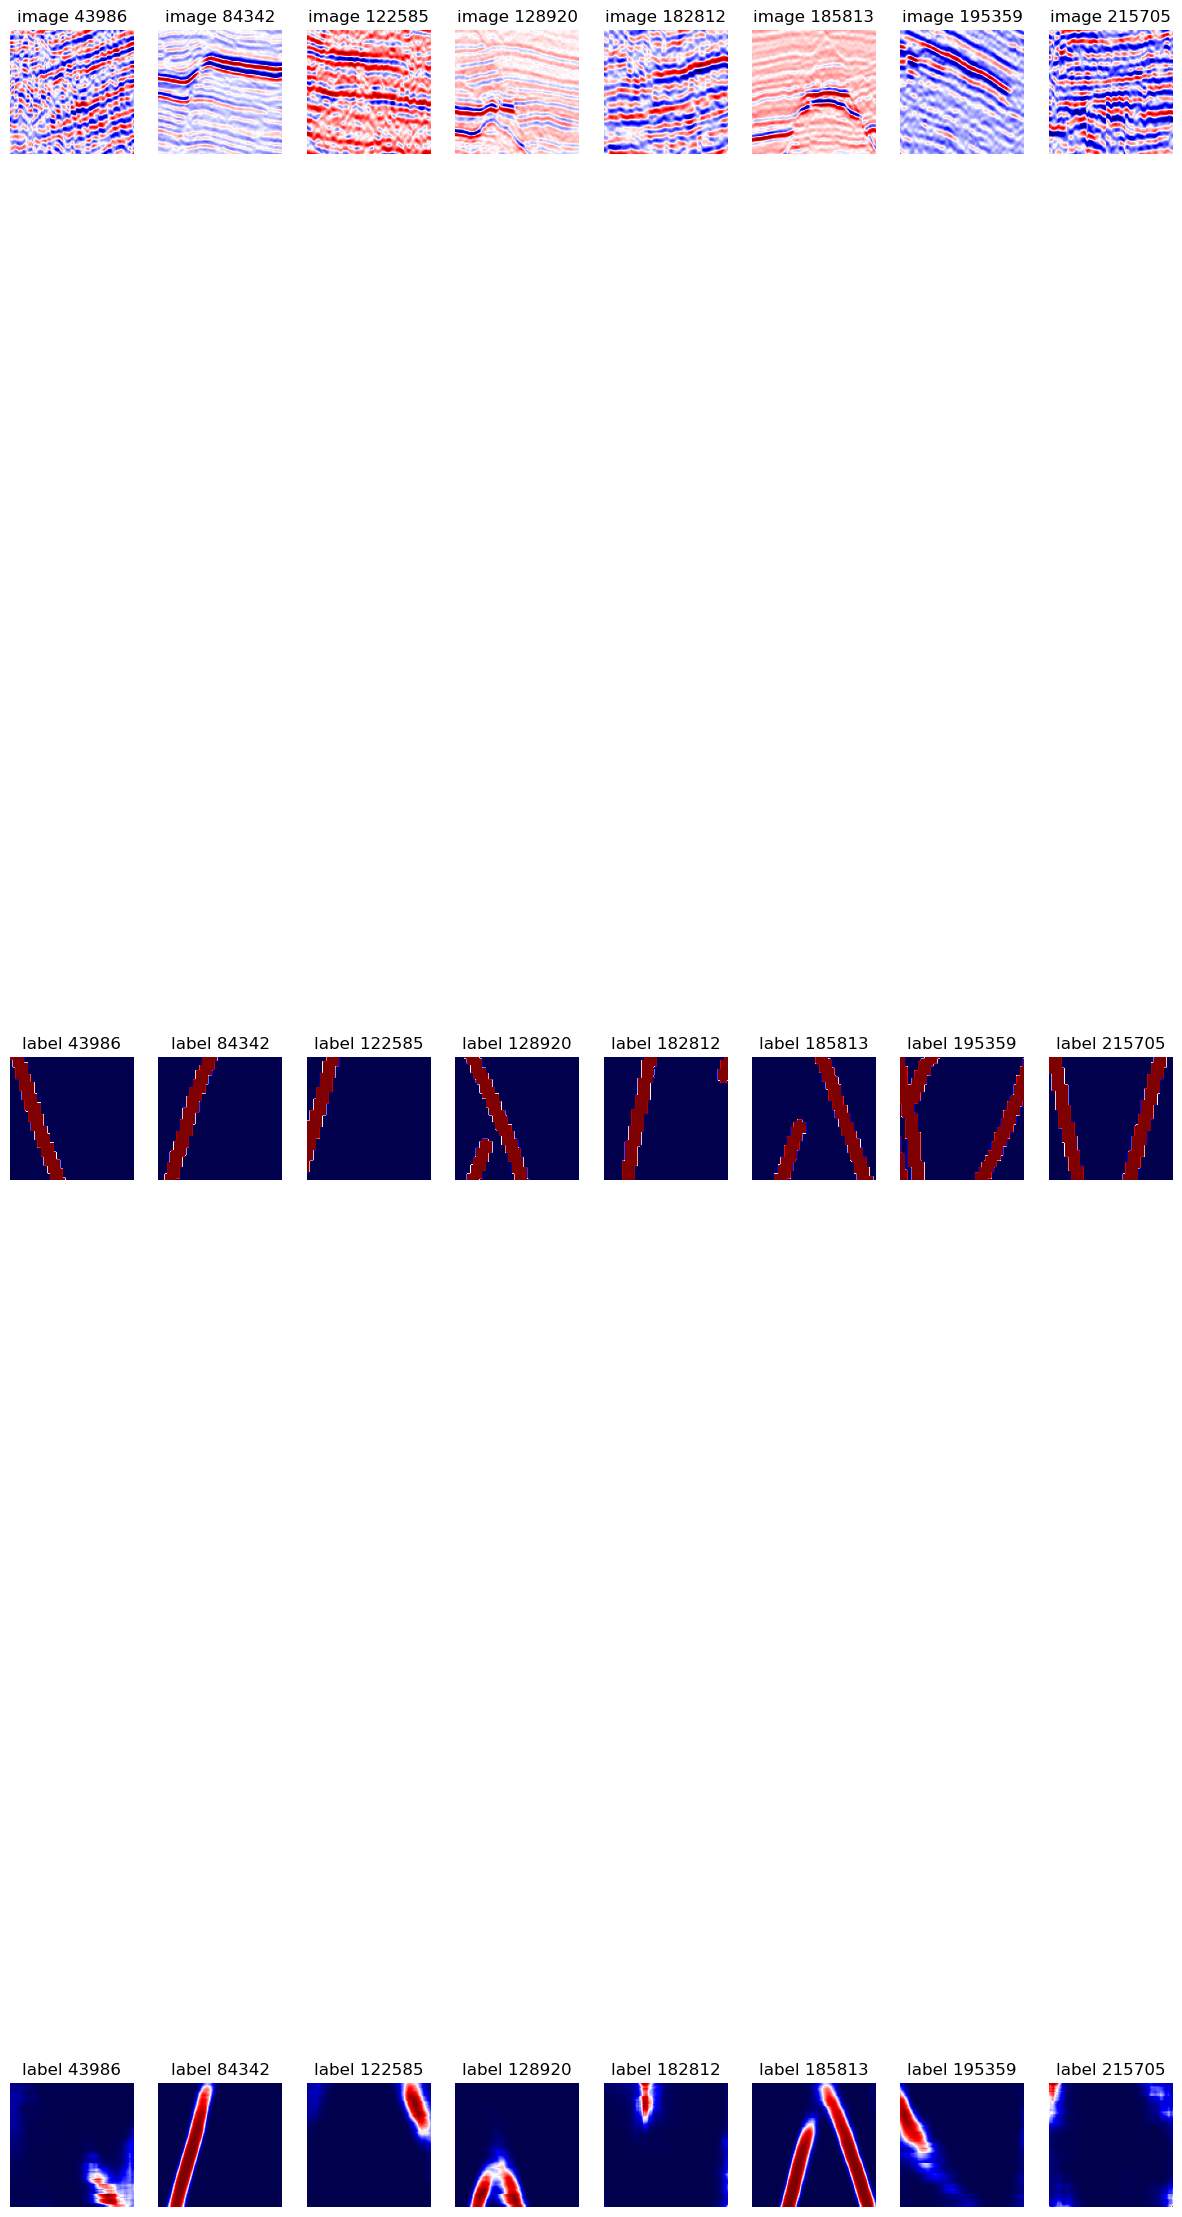

In [15]:

if INTERACTIVE_SESSION:
    seis.display_sample_images(x_test, y_test, y_pred)
    

In [16]:

scores = conf.evaluate_sklearn(y_test, y_pred,report=True)
print(scores)

evaluation elapsed time:___111.68___minutes
                      0             1  accuracy     macro avg  weighted avg
precision  9.300000e-01  7.600000e-01      0.92  8.500000e-01  9.100000e-01
recall     9.800000e-01  3.900000e-01      0.92  6.900000e-01  9.200000e-01
f1-score   9.600000e-01  5.200000e-01      0.92  7.400000e-01  9.100000e-01
support    1.841265e+09  2.242436e+08      0.92  2.065508e+09  2.065508e+09
{'Avg-precision': 0.63, 'f1-score(ODS)': 0.52}
